# RFM Customer Segmentation & Cohort Analysis

This project is part of my analytics capstone work, where I explore how businesses can use customer data to drive smarter decisions.

In this notebook, I:

- Use **RFM (Recency, Frequency, Monetary)** analysis to quantify customer value.
- Apply **K-Means clustering** to create meaningful customer segments.
- Practice **data cleaning**, **EDA**, and **visualization** on a real-world transactions dataset.
- Build **cohorts** and run **cohort analysis** to study retention patterns over time.

The notebook assumes you’re comfortable with Python and have a basic understanding of **K-Means clustering**.


###Problem Statement

Businesses often struggle to answer key questions such as:

Who are my most valuable customers?

Which customers are likely to churn?

How frequently do customers purchase?

How does customer behavior change over time?

What retention patterns do different customer cohorts show?

This project aims to solve these problems by:

Quantifying customer behavior using the RFM model.

Segmenting customers using K-Means clustering to support targeted marketing strategies.

Understanding retention through cohort analysis to help businesses improve long-term engagement.

The final outcome is a structured view of customer segments and actionable business insights that can help drive revenue and optimize marketing decisions.

### Dataset

Using the Online Retail dataset from the UCI Machine Learning Repository for exploratory data analysis, Customer Segmentation, RFM Analysis, K-Means Clustering and Cohort Analysis.

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

Feature Information:

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
Description: Product (item) name. Nominal.
Quantity: The quantities of each product (item) per transaction. Numeric.
InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated.
UnitPrice: Unit price. Numeric, Product price per unit in sterling.
CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
Country: Country name. Nominal, the name of the country where each customer resides.

# 1. Data Cleaning & Exploratory Data Analysis

## Import Modules, Load Data & Data Review

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df=pd.read_csv('/content/OnlineRetail.csv', encoding='latin1')
df.head()

In [ ]:
def explain(attribute):
    features= {'InvoiceNo': "Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.",
    'StockCode': 'Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.',
    'Description': 'Product (item) name. Nominal.',
    'Quantity': 'The quantities of each product (item) per transaction. Numeric.',
    'InvoiceDate': 'Invice Date and time. Numeric, the day and time when each transaction was generated.',
    'UnitPrice': 'Unit price. Numeric, Product price per unit in sterling.',
    'CustomerID': 'Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.',
    'Country': 'Country name. Nominal, the name of the country where each customer resides.'}
    return features[attribute]


### Descriptive Analysis

In [ ]:
df.duplicated().value_counts()

**Explanation:**
* Repetitive rows should be dropped as this will manipulate the analysis.

In [18]:
df=df.drop_duplicates()

In [19]:
df.shape

(536641, 8)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536641 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    536641 non-null  object 
 1   StockCode    536641 non-null  object 
 2   Description  535187 non-null  object 
 3   Quantity     536641 non-null  int64  
 4   InvoiceDate  536641 non-null  object 
 5   UnitPrice    536641 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      536641 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 36.8+ MB


In [21]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64

In [22]:
df.describe()
# df.describe(include=['O'])

Quantity      UnitPrice     CustomerID
count  536641.000000  536641.000000  401604.000000
mean        9.620029       4.632656   15281.160818
std       219.130156      97.233118    1714.006089
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13939.000000
50%         3.000000       2.080000   15145.000000
75%        10.000000       4.130000   16784.000000
max     80995.000000   38970.000000   18287.000000

**Evaluations:**
* `The CustomerID` and `Description` fields have null values.
* `Quantity` and `UnitPrice` should have a value >= 0, but from the summary above there are negative values for the two columns.

### i. Take a look at relationships between InvoiceNo, Quantity and UnitPrice columns.

We see that there are negative values in the Quantity and UnitPrice columns. These are possibly canceled and returned orders. Let's check it out.

In [23]:
# counts of the negative values in the Quantity
df[df['Quantity'] <0].shape[0]

10587

In [24]:
# counts of the negative values in the UnitPrice
df[df['UnitPrice'] < 0].shape[0]

2

In [25]:
df[df['UnitPrice'] < 0]

InvoiceNo StockCode      Description  Quantity       InvoiceDate  \
299983   A563186         B  Adjust bad debt         1  12-08-2011 14:51   
299984   A563187         B  Adjust bad debt         1  12-08-2011 14:52   

        UnitPrice  CustomerID         Country  
299983  -11062.06         NaN  United Kingdom  
299984  -11062.06         NaN  United Kingdom

In [26]:
df[df['Quantity'] <0].head()

InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D                          Discount        -1   
154   C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235   C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236   C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237   C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   

          InvoiceDate  UnitPrice  CustomerID         Country  
141  01-12-2010 09:41      27.50     14527.0  United Kingdom  
154  01-12-2010 09:49       4.65     15311.0  United Kingdom  
235  01-12-2010 10:24       1.65     17548.0  United Kingdom  
236  01-12-2010 10:24       0.29     17548.0  United Kingdom  
237  01-12-2010 10:24       0.29     17548.0  United Kingdom

**Explanation:**
* It is exceptional to have Negative Quantity and Unit Price. We cannot use these rows for the analysis. Therefore we will drop them.

### ii. What does the letter "C" in the InvoiceNo column mean?

In [27]:
explain('InvoiceNo')

"Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation."

If the invoice number starts with the letter "C", it means the order was cancelled. Or those who abandon their order.

In [28]:
df['cancellation']=df.InvoiceNo.str.extract('([C])').fillna(0).replace({'C':1})
df['cancellation'].value_counts()

/tmp/ipython-input-3645149312.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['cancellation']=df.InvoiceNo.str.extract('([C])').fillna(0).replace({'C':1})


cancellation
0    527390
1      9251
Name: count, dtype: int64

When we filter canceled orders by Quantity> 0 or filter non-canceled orders by Quantity <0 nothing returns, this confirms that negative values mean the order was canceled. So lets find out how many orders were cancelled?

In [29]:
df[(df.cancellation==1) & (df.Quantity>0)]

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, cancellation]
Index: []

**Evaluations:**
* we can say, if cancellation = 1, quantity < 0

#### 9288 or about 36% of the orders were cancelled. Looking deeper into why these orders were cancelled may prevent future cancellations. Now let's find out what a negative UnitPrice means.


In [30]:
df['cancellation'].value_counts()

cancellation
0    527390
1      9251
Name: count, dtype: int64

In [31]:
# Proportion of the customers canceled their order
df[df.cancellation==1]['CustomerID'].nunique() / df['CustomerID'].nunique()*100

36.34492223238792

In [32]:
# Proportion of the canceled order
df[df.cancellation==1]['InvoiceNo'].nunique() /df[['InvoiceNo']].nunique()*100

InvoiceNo    14.810811
dtype: float64

![indir%20%281%29.png](attachment:indir%20%281%29.png)

**Explanation:**
* Iptal edilen faturalarin quantity degerleri, o faturaya en yakin tarihli gecmis ozdes faturadan cikarilarak data sette duzeltme yapilmalidir. Bu duzeltme bir sonraki versiyonda yapilacaktir. Bu versiyonda yalniz pozitif degerli quantityler ile analize devam edildi.

### iii. Handling Missing Values

Since the customer ID's are missing, lets assume these orders were not made by the customers already in the data set because those customers already have ID's.

We also don't want to assign these orders to those customers because this would alter the insights we draw from the data.


In [33]:
df[df.cancellation==1]['CustomerID'].value_counts(dropna=False).head(5)

CustomerID
NaN        379
14911.0    226
17841.0    136
17511.0    113
15311.0    112
Name: count, dtype: int64

### iv. Clean the Data from the Noise and Missing Values

In [34]:
# Drop CustomerID with null value
df = df[df.CustomerID.notnull()]

In [35]:
# Drop Quantity and UnitPrice with negative value
df = df[(df.Quantity > 0) & (df.UnitPrice > 0)]

In [36]:
details = summary(df)
display(details.sort_values(by='Uniques', ascending=False))

Data shape: (392692, 9)
___________________________
Data Types:
Types
object     5
float64    2
int64      2
Name: count, dtype: int64
___________________________


Types  Counts  Uniques  Nulls                             Min  \
InvoiceNo      object  392692    18532      0                          536365   
InvoiceDate    object  392692    17282      0                01-02-2011 08:23   
CustomerID    float64  392692     4338      0                         12346.0   
Description    object  392692     3877      0   4 PURPLE FLOCK DINNER CANDLES   
StockCode      object  392692     3665      0                           10002   
UnitPrice     float64  392692      440      0                           0.001   
Quantity        int64  392692      301      0                               1   
Country        object  392692       37      0                       Australia   
cancellation    int64  392692        1      0                               0   

                                           Max  
InvoiceNo                               581587  
InvoiceDate                   31-10-2011 17:13  
CustomerID                             18287.0  
Description   ZINC WIRE SWEETHEART LETTER TRAY  
StockCode                                 POST  
UnitPrice                              8142.75  
Quantity                                 80995  
Country                            Unspecified  
cancellation                                 0

In [37]:
df[df.cancellation==1]

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, cancellation]
Index: []

In [38]:
df=df.drop('cancellation',axis=1)

In [39]:
df

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

             InvoiceDate  UnitPrice  CustomerID         Country  
0       01-12-2010 08:26       2.55     17850.0  United Kingdom  
1       01-12-2010 08:26       3.39     17850.0  United Kingdom  
2       01-12-2010 08:26       2.75     17850.0  United Kingdom  
3       01-12-2010 08:26       3.39     17850.0  United Kingdom  
4       01-12-2010 08:26       3.39     17850.0  United Kingdom  
...                  ...        ...         ...             ...  
541904  09-12-2011 12:50       0.85     12680.0          France  
541905  09-12-2011 12:50       2.10     12680.0          France  
541906  09-12-2011 12:50       4.15     12680.0          France  
541907  09-12-2011 12:50       4.15     12680.0          France  
541908  09-12-2011 12:50       4.95     12680.0          France  

[392692 rows x 8 columns]

### v. Explore the Orders


1. Find the unique number of InvoiceNo  per customer

In [40]:
# Her musterinin siparis sayisi
df.groupby('CustomerID')['InvoiceNo'].nunique().sort_values(ascending=False)

CustomerID
12748.0    209
14911.0    201
17841.0    124
13089.0     97
14606.0     93
          ... 
18213.0      1
18215.0      1
18269.0      1
18274.0      1
18240.0      1
Name: InvoiceNo, Length: 4338, dtype: int64

2. What's the average number of unqiue items per order or per customer?

In [41]:
# Her bir musterinin her siparisteki unique products sayisinin ortalamasi
mean_of_unique_items= round(df.groupby(['CustomerID',
                      'InvoiceNo']).agg({'StockCode':lambda x:x.nunique()}).groupby('CustomerID')['StockCode'].mean(),
                      1).sort_values(ascending=False)
mean_of_unique_items

CustomerID
14096.0    298.8
12378.0    219.0
16984.0    191.0
12688.0    171.0
15464.0    155.0
           ...  
18184.0      1.0
18273.0      1.0
18233.0      1.0
18268.0      1.0
12346.0      1.0
Name: StockCode, Length: 4338, dtype: float64

3. Let's see how this compares to the number of unique products per customer.

In [42]:
# Her musterinin satin aldigi unique product sayisi
num_of_unique_product= pd.DataFrame(df.groupby('CustomerID').StockCode.nunique()).rename(columns={'StockCode':'num_of_unique_product'})

# Her musterinin siparis sayisi
num_of_order = df.groupby('CustomerID').InvoiceNo.nunique()

In [43]:
pd.concat([mean_of_unique_items,
           num_of_order,
           num_of_unique_product],
           axis=1).rename(columns={'StockCode': "mean_of_unique_items",
                                   'InvoiceNo': 'num_of_order'}).sort_values('num_of_order', ascending=False)

mean_of_unique_items  num_of_order  num_of_unique_product
CustomerID                                                           
12748.0                     20.5           209                   1768
14911.0                     28.2           201                   1787
17841.0                     60.3           124                   1323
13089.0                     18.7            97                    636
14606.0                     28.6            93                    819
...                          ...           ...                    ...
15524.0                      1.0             1                      1
15802.0                      1.0             1                      1
15940.0                      1.0             1                      1
18022.0                    141.0             1                    141
16800.0                    148.0             1                    148

[4338 rows x 3 columns]

### vi. Explore Customers by Country

1. What's the total revenue per country?

In [44]:
df

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

             InvoiceDate  UnitPrice  CustomerID         Country  
0       01-12-2010 08:26       2.55     17850.0  United Kingdom  
1       01-12-2010 08:26       3.39     17850.0  United Kingdom  
2       01-12-2010 08:26       2.75     17850.0  United Kingdom  
3       01-12-2010 08:26       3.39     17850.0  United Kingdom  
4       01-12-2010 08:26       3.39     17850.0  United Kingdom  
...                  ...        ...         ...             ...  
541904  09-12-2011 12:50       0.85     12680.0          France  
541905  09-12-2011 12:50       2.10     12680.0          France  
541906  09-12-2011 12:50       4.15     12680.0          France  
541907  09-12-2011 12:50       4.15     12680.0          France  
541908  09-12-2011 12:50       4.95     12680.0          France  

[392692 rows x 8 columns]

In [45]:
df['TotalPrice'] = df['UnitPrice']*df['Quantity']

In [46]:
df2=pd.DataFrame(df.groupby('Country').TotalPrice.sum().apply(lambda x: round(x,2))).sort_values('TotalPrice',ascending=False)
# df2=df.groupby('Country').agg({'TotalPrice': lambda x: x.sum()}).sort_values('TotalPrice',ascending=False)

df2['perc_of_TotalPrice']=round(df2.TotalPrice/df2.TotalPrice.sum()*100,2)
df2

TotalPrice  perc_of_TotalPrice
Country                                             
United Kingdom        7285024.64               81.97
Netherlands            285446.34                3.21
EIRE                   265262.46                2.98
Germany                228678.40                2.57
France                 208934.31                2.35
Australia              138453.81                1.56
Spain                   61558.56                0.69
Switzerland             56443.95                0.64
Belgium                 41196.34                0.46
Sweden                  38367.83                0.43
Japan                   37416.37                0.42
Norway                  36165.44                0.41
Portugal                33375.84                0.38
Finland                 22546.08                0.25
Singapore               21279.29                0.24
Channel Islands         20440.54                0.23
Denmark                 18955.34                0.21
Italy                   17483.24                0.20
Cyprus                  13502.85                0.15
Austria                 10198.68                0.11
Poland                   7334.65                0.08
Israel                   7215.84                0.08
Greece                   4760.52                0.05
Iceland                  4310.00                0.05
Canada                   3666.38                0.04
USA                      3580.39                0.04
Malta                    2725.59                0.03
Unspecified              2660.77                0.03
United Arab Emirates     1902.28                0.02
Lebanon                  1693.88                0.02
Lithuania                1661.06                0.02
European Community       1300.25                0.01
Brazil                   1143.60                0.01
RSA                      1002.31                0.01
Czech Republic            826.74                0.01
Bahrain                   548.40                0.01
Saudi Arabia              145.92                0.00

2. Visualize number of customer per country

In [47]:
df2['customer_num']=df.groupby('Country').CustomerID.nunique()
df2['customer_rate']=round(df2.customer_num/df2.customer_num.sum()*100,2)
df2.head(5)

TotalPrice  perc_of_TotalPrice  customer_num  customer_rate
Country                                                                    
United Kingdom  7285024.64               81.97          3920          90.20
Netherlands      285446.34                3.21             9           0.21
EIRE             265262.46                2.98             3           0.07
Germany          228678.40                2.57            94           2.16
France           208934.31                2.35            87           2.00

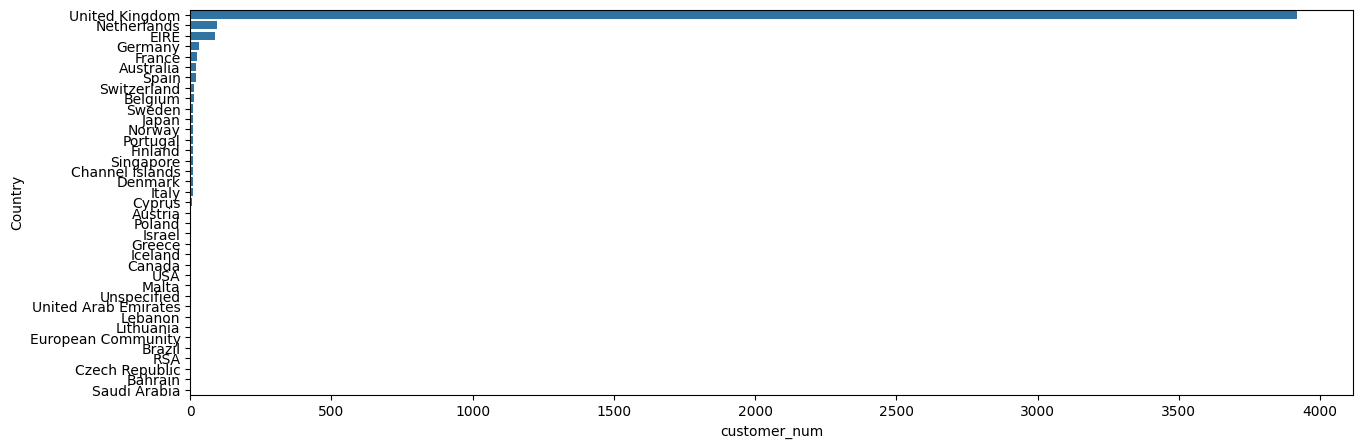

In [48]:
plt.figure(figsize=(15,5))
sns.barplot(y=df2.index, x=df2.customer_num.sort_values(ascending=False));

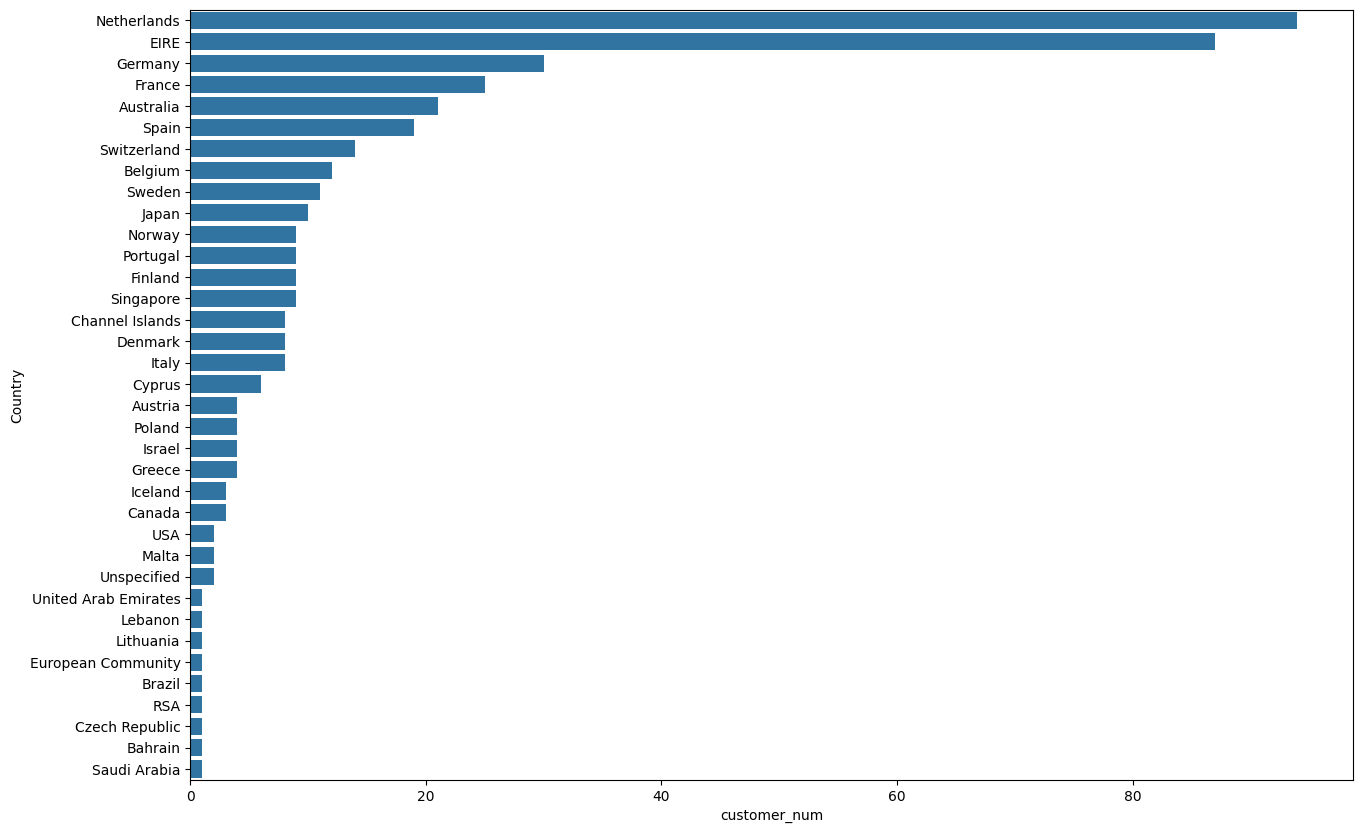

In [49]:
plt.figure(figsize=(15,10))
sns.barplot(y=df2.iloc[1:].index, x=df2.iloc[1:].customer_num.sort_values(ascending=False));

3. Visualize total cost per country

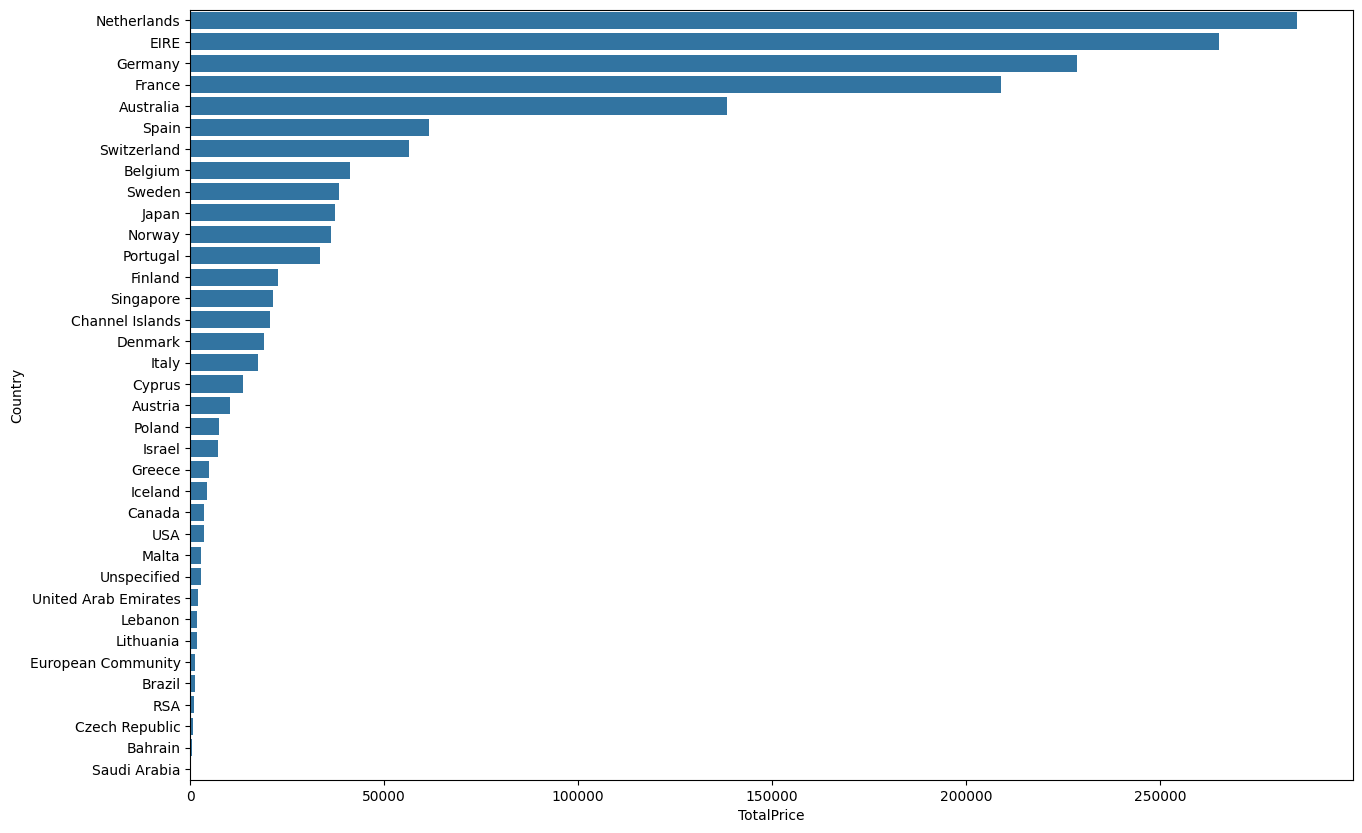

In [50]:
plt.figure(figsize=(15,10))
sns.barplot(y=df2.iloc[1:].index, x=df2.iloc[1:].TotalPrice.sort_values(ascending=False));

#### The UK not only has the most sales revenue, but also the most customers. Since the majority of this data set contains orders from the UK, we can explore the UK market further by finding out what products the customers buy together and any other buying behaviors to improve our sales and targeting strategy.

### vii. Explore the UK Market


1. Create df_uk DataFrame

In [51]:
df_uk=df[df.Country=='United Kingdom']
df_uk.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom       15.30  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom       20.34  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom       22.00  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom       20.34  
4  01-12-2010 08:26       3.39     17850.0  United Kingdom       20.34

2. What are the most popular products that are bought in the UK?

In [52]:
pd.DataFrame(df_uk.StockCode.value_counts().head(10))

count
StockCode       
85123A      1936
85099B      1461
22423       1417
84879       1320
47566       1300
20725       1135
20727       1022
22720       1013
23203        993
22383        977

**Explanation**
* There is no special meaning of 'A' and 'B' letter at the end fo some StockCodes

### We will continue analyzing the UK transactions with customer segmentation.

# 2. RFM Analysis

In the age of the internet and e-commerce, companies that do not expand their businesses online or utilize digital tools to reach their customers will run into issues like scalability and a lack of digital precsence. An important marketing strategy e-commerce businesses use for analyzing and predicting customer value is customer segmentation. Customer data is used to sort customers into group based on their behaviors and preferences.

**[RFM](https://www.putler.com/rfm-analysis/) (Recency, Frequency, Monetary) Analysis** is a customer segmentation technique for analyzing customer value based on past buying behavior. RFM analysis was first used by the direct mail industry more than four decades ago, yet it is still an effective way to optimize your marketing.
<br>
<br>
Our goal in this Notebook is to cluster the customers in our data set to:
 - Recognize who are our most valuable customers
 - Increase revenue
 - Increase customer retention
 - Learn more about the trends and behaviors of our customers
 - Define customers that are 5-Lost Customers

We will tart with **RFM Analysis** and then compliment our findings with predictive analysis using **K-Means Clustering Algorithms.**

- RECENCY (R): Time since last purchase
- FREQUENCY (F): Total number of purchases
- MONETARY VALUE (M): Total monetary value




Benefits of RFM Analysis

- Increased customer retention
- Increased response rate
- Increased conversion rate
- Increased revenue

RFM Analysis answers the following questions:
 - Who are our best customers?
 - Who has the potential to be converted into more profitable customers?
 - Which customers do we need to retain?
 - Which group of customers is most likely to respond to our marketing campaign?


### i. Import Libraries

In [53]:
from datetime import datetime as dt
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

### ii. Review df_uk DataFrame

In [55]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format="%d-%m-%Y %H:%M")

df_uk=df[df.Country=='United Kingdom']
df_uk.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34

### iii. Recency: Days since last purchase
To calculate the recency values, follow these steps in order:

1. To calculate recency, we need to choose a date as a point of reference to evaluate how many days ago was the customer's last purchase.
2. Create a new column called Date which contains the invoice date without the timestamp
3. Group by CustomerID and check the last date of purchase
4. Calculate the days since last purchase
5. Drop Last_Purchase_Date since we don't need it anymore
6. Plot RFM distributions

1. Choose a date as a point of reference to evaluate how many days ago was the customer's last purchase.

In [56]:
# a point of reference date

ref_date = max(df['InvoiceDate'])
ref_date

Timestamp('2011-12-09 12:50:00')

2. Create a new column called Date which contains the invoice date without the timestamp

In [57]:
df_uk['Date']=df_uk['InvoiceDate'].apply(lambda x: x.date())
df_uk.head(3)

InvoiceNo StockCode                         Description  Quantity  \
0    536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                 WHITE METAL LANTERN         6   
2    536365    84406B      CREAM CUPID HEARTS COAT HANGER         8   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00   

         Date  
0  2010-12-01  
1  2010-12-01  
2  2010-12-01

3. Group by CustomerID and check the last date of purchase

In [58]:
df_uk['Last_Purchase_Date']=df_uk.groupby(['CustomerID'])['Date'].transform(max)
# df_uk.groupby('CustomerID').agg({'Date': lambda x:x.max()})
df_uk.head(5)

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   

         Date Last_Purchase_Date  
0  2010-12-01         2010-12-02  
1  2010-12-01         2010-12-02  
2  2010-12-01         2010-12-02  
3  2010-12-01         2010-12-02  
4  2010-12-01         2010-12-02

4. Calculate the days since last purchase

In [62]:
df_uk['Recency'] = (ref_date.date() - df_uk['Last_Purchase_Date']).apply(lambda x: x.days)

# df_uk.groupby('CustomerID').agg({'Date': lambda x: (today.date() - x.max()).days})
df_uk.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   

         Date Last_Purchase_Date  Recency  
0  2010-12-01         2010-12-02      372  
1  2010-12-01         2010-12-02      372  
2  2010-12-01         2010-12-02      372  
3  2010-12-01         2010-12-02      372  
4  2010-12-01         2010-12-02      372

In [63]:
df_uk.Recency.value_counts().sort_index()

Recency
0      12341
1      31709
2      18224
3      13749
4      19841
       ...  
368       75
369      169
371       98
372      487
373      431
Name: count, Length: 302, dtype: int64

5. Drop Last_Purchase_Date since we don't need it anymore

In [64]:
df_uk = df_uk.drop('Last_Purchase_Date',axis=1)

6. Plot RFM distributions

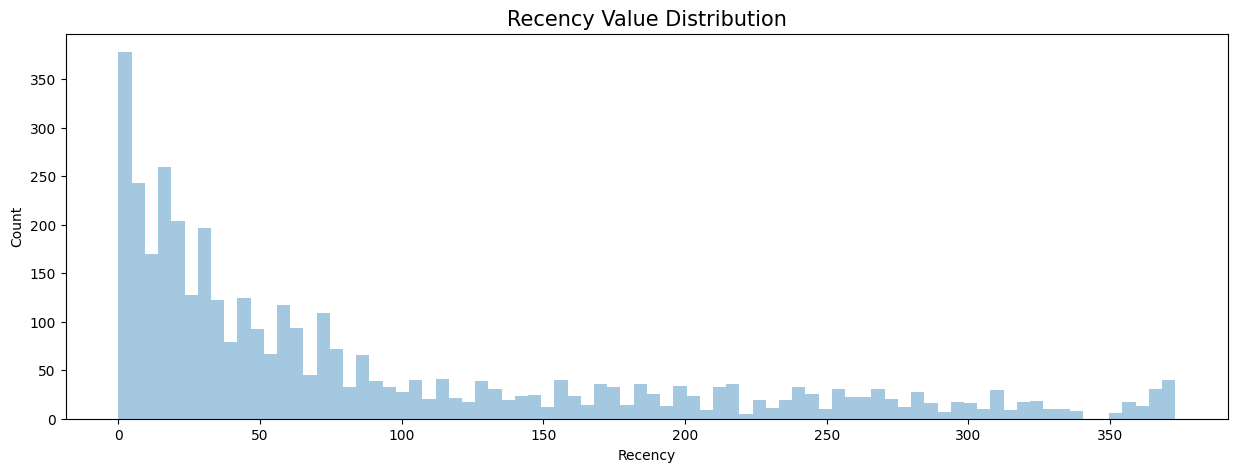

In [65]:
plt.subplots(figsize=(15, 5))
sns.distplot(df_uk.groupby('CustomerID')['Recency'].max(), kde=False, bins=80)
plt.title('Recency Value Distribution', fontsize = 15)
plt.xlabel('Recency')
plt.ylabel('Count');

### iv. Frequency: Number of purchases

To calculate how many times a customer purchased something, we need to count how many invoices each customer has. To calculate the frequency values, follow these steps in order:

1. Make a copy of df_uk and drop duplicates

In [66]:
df_uk=df_uk.drop_duplicates()

2. Calculate the frequency of purchases

In [67]:
df_uk['Frequency'] = df_uk.groupby('CustomerID').InvoiceNo.transform('nunique')

3. Plot RFM distributions

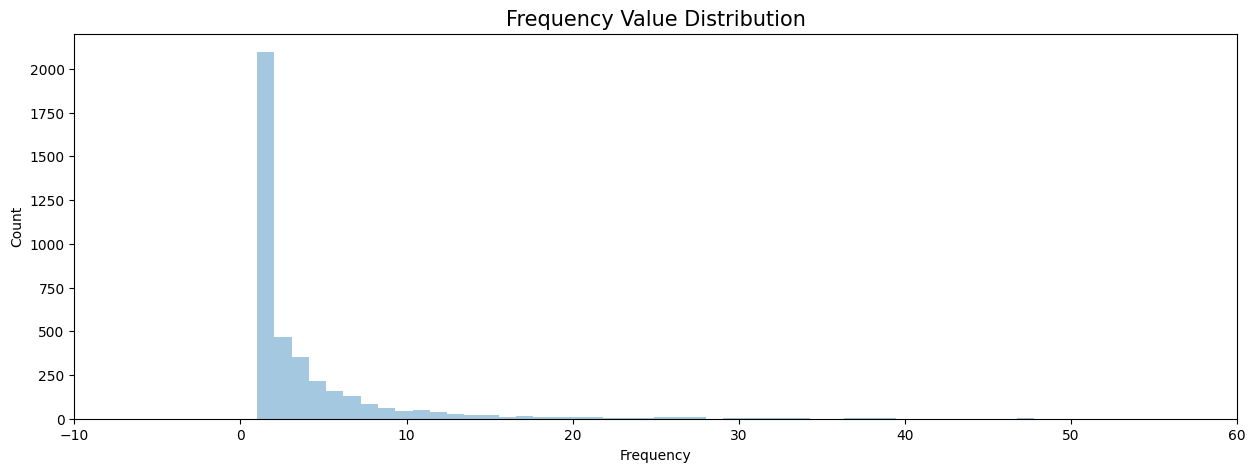

In [68]:
plt.figure(figsize=(15, 5))
sns.distplot(df_uk.groupby('CustomerID')['Frequency'].max(), kde=False, bins=200)
plt.title('Frequency Value Distribution', fontsize = 15)
plt.xlim(-10, 60)
plt.xlabel('Frequency')
plt.ylabel('Count');

### v. Monetary: Total amount of money spent

The monetary value is calculated by adding together the cost of the customers' purchases.


1. Calculate sum total cost by customers and named "Monetary"

In [69]:
df_uk['Monetary'] = df_uk.groupby('CustomerID').TotalPrice.transform('sum')

2. Plot RFM distributions

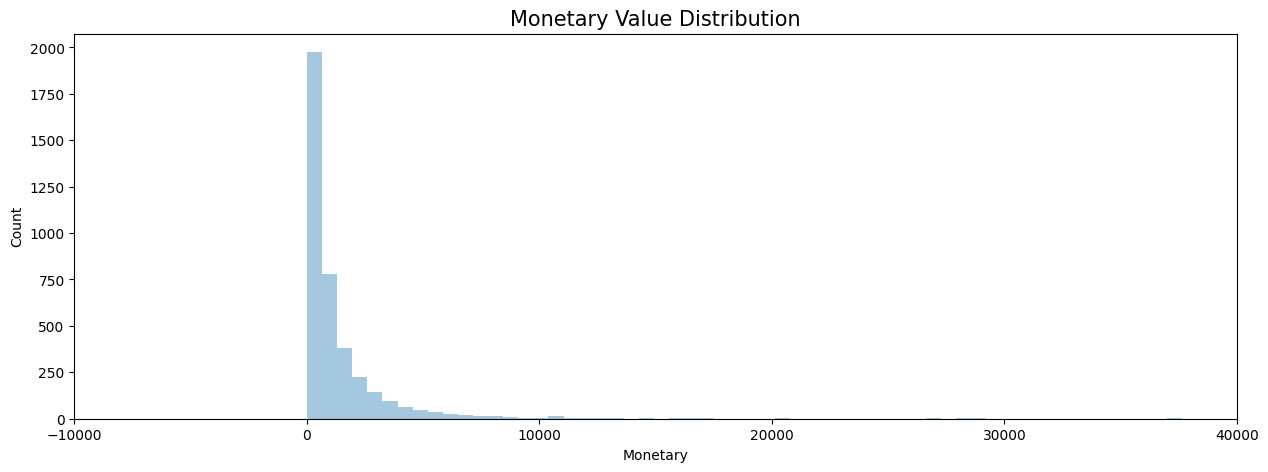

In [70]:
plt.subplots(figsize=(15, 5))
sns.distplot(df_uk.groupby('CustomerID')['Monetary'].max(), kde=False, bins=400)
plt.title('Monetary Value Distribution', fontsize = 15)
plt.xlim(-10000, 40000)
plt.xlabel('Monetary')
plt.ylabel('Count');

### vi. Create RFM Table
Merge the recency, frequency and motetary dataframes

In [71]:
df_rfm = df_uk[['Recency','Frequency','Monetary']].drop_duplicates().rename(index=df_uk['CustomerID'])
df_rfm.sort_index()

Recency  Frequency  Monetary
12346.0      325          1  77183.60
12747.0        2         11   4196.01
12748.0        0        209  33053.19
12749.0        3          5   4090.88
12820.0        3          4    942.34
...          ...        ...       ...
18280.0      277          1    180.60
18281.0      180          1     80.82
18282.0        7          2    178.05
18283.0        3         16   2045.53
18287.0       42          3   1837.28

[3920 rows x 3 columns]

# 3. Customer Segmentation with RFM Scores

Businesses have this ever-lasting urge to understand their customers. The better you understand the customer, the better you serve them, and the higher the financial gain you receive from that customer. Since the dawn of trade, this process of understanding customers for a strategic gain has been there practiced and this task is known majorly as [Customer Segmentation](https://clevertap.com/blog/rfm-analysis/).
Well as the name suggests, Customer Segmentation could segment customers according to their precise needs. Some of the common ways of segmenting customers are based on their Recency-Frequency-Monatory values, their demographics like gender, region, country, etc, and some of their business-crafted scores. You will use Recency-Frequency-Monatory values for this case.

In this section, you will create an RFM Segmentation Table where you segment your customers by using the RFM table. For example, you can label the best customer as "Big Spenders" and the lost customer as "Lost Customer".

## Calculate RFM Scoring

The simplest way to create customer segments from an RFM model is by using **Quartiles**. We will assign a score from 1 to 4 to each category (Recency, Frequency, and Monetary) with 4 being the highest/best value. The final RFM score is calculated by combining all RFM values. For Customer Segmentation, you will use the df_rfm data set resulting from the RFM analysis.
<br>
<br>

**Note**:For better detail, the data can be assigned to more clusters, we will cluster them in 6 different levels.

1. Divide the df_rfm into quarters

In [72]:
quantiles = df_rfm.quantile(q=[0.25,0.50,0.75])
quantiles

Recency  Frequency  Monetary
0.25     17.0        1.0   298.185
0.50     50.0        2.0   644.975
0.75    142.0        5.0  1571.285

> Interquartel range (IQR) e gore 4 grup ta clustering yapacagiz

### i. Creating the RFM Segmentation Table


1. Create two functions, one for Recency and one for Frequency and Monetary. For Recency, customers in the first quarter should be scored as 4, this represents the highest Recency value. Conversely, for Frequency and Monetary, customers in the last quarter should be scored as 4, representing the highest Frequency and Monetary values.

In [73]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)

def R_Point(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [74]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)

def FM_Point(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

2. Score customers from 1 to 4 by applying the functions you have created. Also create separate score column for each value.

In [75]:
df_rfm['R_Quartile'] = df_rfm['Recency'].apply(R_Point, args=('Recency',quantiles))
df_rfm['F_Quartile'] = df_rfm['Frequency'].apply(FM_Point, args=('Frequency',quantiles))
df_rfm['M_Quartile'] = df_rfm['Monetary'].apply(FM_Point, args=('Monetary',quantiles))

In [77]:
df_rfm

Recency  Frequency  Monetary  R_Quartile  F_Quartile  M_Quartile
17850.0      372         34   5391.21           1           4           4
13047.0       31         10   3237.54           3           4           4
13748.0       95          5    948.25           2           3           3
15100.0      333          3    876.00           1           3           3
15291.0       25         15   4668.30           3           4           4
...          ...        ...       ...         ...         ...         ...
15471.0        2          1    454.48           4           1           2
13436.0        1          1    196.89           4           1           1
15520.0        1          1    343.50           4           1           2
13298.0        1          1    360.00           4           1           2
14569.0        1          1    227.39           4           1           1

[3920 rows x 6 columns]

3. Now that scored each customer, you'll combine the scores for segmentation.

In [78]:
df_rfm['RFM_Scores'] = df_rfm.R_Quartile.apply(str) + df_rfm.F_Quartile.apply(str) + df_rfm.M_Quartile.apply(str)
df_rfm

Recency  Frequency  Monetary  R_Quartile  F_Quartile  M_Quartile  \
17850.0      372         34   5391.21           1           4           4   
13047.0       31         10   3237.54           3           4           4   
13748.0       95          5    948.25           2           3           3   
15100.0      333          3    876.00           1           3           3   
15291.0       25         15   4668.30           3           4           4   
...          ...        ...       ...         ...         ...         ...   
15471.0        2          1    454.48           4           1           2   
13436.0        1          1    196.89           4           1           1   
15520.0        1          1    343.50           4           1           2   
13298.0        1          1    360.00           4           1           2   
14569.0        1          1    227.39           4           1           1   

        RFM_Scores  
17850.0        144  
13047.0        344  
13748.0        233  
15100.0        133  
15291.0        344  
...            ...  
15471.0        412  
13436.0        411  
15520.0        412  
13298.0        412  
14569.0        411  

[3920 rows x 7 columns]

4. Define RFM_Points function that tags customers by using RFM_Scores and Create a new variable RFM_Scores_Segment

**Method-1**

* If RFM_Scores == '444', then "1-Best Customers"
* If RFM_Scores == 'X4X', then "2-Loyal Customers"
* If RFM_Scores == 'XX4', then "3-Big Spenders"
* If RFM_Scores == '244', then "4-Almost Lost"
* If RFM_Scores == '144', then "5-Lost Customers"
* If RFM_Scores == '111', then "6-Lost Cheap Customers"

In [79]:
label = list(np.zeros(len(df_rfm)))

for i in range(len(df_rfm)):
    if df_rfm['RFM_Scores'].iloc[i] =='444': label[i] = "1-Best Customers"
    elif df_rfm['RFM_Scores'].iloc[i][1]=='4': label[i] = "2-Loyal Customers"
    elif df_rfm['RFM_Scores'].iloc[i][2]=='4': label[i] = "3-Big Spenders"
    elif df_rfm['RFM_Scores'].iloc[i]=='244' : label[i] = "4-Almost Lost"
    elif df_rfm['RFM_Scores'].iloc[i]=='144' : label[i] = "5-Lost Customers"
    elif df_rfm['RFM_Scores'].iloc[i] =='111' : label[i] = "6-Lost Cheap Customers"

df_rfm['RFM_Scores_Segments'] = label
df_rfm

Recency  Frequency  Monetary  R_Quartile  F_Quartile  M_Quartile  \
17850.0      372         34   5391.21           1           4           4   
13047.0       31         10   3237.54           3           4           4   
13748.0       95          5    948.25           2           3           3   
15100.0      333          3    876.00           1           3           3   
15291.0       25         15   4668.30           3           4           4   
...          ...        ...       ...         ...         ...         ...   
15471.0        2          1    454.48           4           1           2   
13436.0        1          1    196.89           4           1           1   
15520.0        1          1    343.50           4           1           2   
13298.0        1          1    360.00           4           1           2   
14569.0        1          1    227.39           4           1           1   

        RFM_Scores RFM_Scores_Segments  
17850.0        144   2-Loyal Customers  
13047.0        344   2-Loyal Customers  
13748.0        233                 0.0  
15100.0        133                 0.0  
15291.0        344   2-Loyal Customers  
...            ...                 ...  
15471.0        412                 0.0  
13436.0        411                 0.0  
15520.0        412                 0.0  
13298.0        412                 0.0  
14569.0        411                 0.0  

[3920 rows x 8 columns]

In [80]:
df_rfm.RFM_Scores_Segments.value_counts()

RFM_Scores_Segments
0.0                       2420
1-Best Customers           423
6-Lost Cheap Customers     395
2-Loyal Customers          368
3-Big Spenders             314
Name: count, dtype: int64

In [81]:
Loyal_Customers=['433']
Big_Spenders=['413','432','423']
Almost_Lost=['333','233','422','331','313','431','323']
Lost_Customers=['222','311','322','223','332','411','133','132','312','131','123','213','113','421','412','231','321','232']
Lost_Cheap_Customers=['122','211','112','121','212','221']

In [82]:
for i in range(len(df_rfm)):
    if df_rfm['RFM_Scores'].iloc[i] in Loyal_Customers : label[i] = "2-Loyal Customers"
    elif df_rfm['RFM_Scores'].iloc[i] in Big_Spenders : label[i] = "3-Big Spenders"
    elif df_rfm['RFM_Scores'].iloc[i] in Almost_Lost : label[i] = "4-Almost Lost"
    elif df_rfm['RFM_Scores'].iloc[i] in Lost_Customers : label[i] = "5-Lost Customers"
    elif df_rfm['RFM_Scores'].iloc[i] in Lost_Cheap_Customers  : label[i] = "6-Lost Cheap Customers"

df_rfm['RFM_Scores_Segments'] = label
df_rfm

Recency  Frequency  Monetary  R_Quartile  F_Quartile  M_Quartile  \
17850.0      372         34   5391.21           1           4           4   
13047.0       31         10   3237.54           3           4           4   
13748.0       95          5    948.25           2           3           3   
15100.0      333          3    876.00           1           3           3   
15291.0       25         15   4668.30           3           4           4   
...          ...        ...       ...         ...         ...         ...   
15471.0        2          1    454.48           4           1           2   
13436.0        1          1    196.89           4           1           1   
15520.0        1          1    343.50           4           1           2   
13298.0        1          1    360.00           4           1           2   
14569.0        1          1    227.39           4           1           1   

        RFM_Scores RFM_Scores_Segments  
17850.0        144   2-Loyal Customers  
13047.0        344   2-Loyal Customers  
13748.0        233       4-Almost Lost  
15100.0        133    5-Lost Customers  
15291.0        344   2-Loyal Customers  
...            ...                 ...  
15471.0        412    5-Lost Customers  
13436.0        411    5-Lost Customers  
15520.0        412    5-Lost Customers  
13298.0        412    5-Lost Customers  
14569.0        411    5-Lost Customers  

[3920 rows x 8 columns]

In [83]:
df_rfm.RFM_Scores_Segments.value_counts().sort_index()

RFM_Scores_Segments
1-Best Customers           423
2-Loyal Customers          527
3-Big Spenders             401
4-Almost Lost              490
5-Lost Customers           963
6-Lost Cheap Customers    1116
Name: count, dtype: int64

In [84]:
df_rfm.groupby('RFM_Scores_Segments').agg({'Recency': ['mean','median','min','max'],
                                           'Frequency': ['mean','median','min','max'],
                                           'Monetary': ['mean','median','min','max','count']}).round(1)

Recency                 Frequency                  \
                          mean median min  max      mean median min  max   
RFM_Scores_Segments                                                        
1-Best Customers           6.7    5.0   0   17      15.8   11.0   6  209   
2-Loyal Customers         35.9   22.0   0  372       7.3    6.0   3   63   
3-Big Spenders            48.0   28.0   0  372       3.5    4.0   1    5   
4-Almost Lost             43.4   33.0   1  142       3.1    3.0   1    5   
5-Lost Customers          77.6   47.0   1  371       1.9    2.0   1    5   
6-Lost Cheap Customers   199.6  201.0  51  373       1.2    1.0   1    2   

                       Monetary                                  
                           mean  median     min       max count  
RFM_Scores_Segments                                              
1-Best Customers         8424.3  3989.6  1591.4  259657.3   423  
2-Loyal Customers        2557.4  1476.1    70.0   80850.8   527  
3-Big Spenders           2858.7  1910.0   342.2  168472.5   401  
4-Almost Lost             913.5   890.7    36.6    1567.5   490  
5-Lost Customers          503.0   440.0     6.9    1564.6   963  
6-Lost Cheap Customers    264.8   241.0     3.8     642.4  1116

**Explanation:**

**Method-2**

In [85]:
df_rfm['RFM_Points'] = df_rfm[['R_Quartile', 'F_Quartile', 'M_Quartile']].sum(axis=1).astype('float')
# df_rfm['RFM_Points'] = df_rfm['R_Quartile'] + df_rfm['F_Quartile'] + df_rfm['M_Quartile']
df_rfm.head()

Recency  Frequency  Monetary  R_Quartile  F_Quartile  M_Quartile  \
17850.0      372         34   5391.21           1           4           4   
13047.0       31         10   3237.54           3           4           4   
13748.0       95          5    948.25           2           3           3   
15100.0      333          3    876.00           1           3           3   
15291.0       25         15   4668.30           3           4           4   

        RFM_Scores RFM_Scores_Segments  RFM_Points  
17850.0        144   2-Loyal Customers         9.0  
13047.0        344   2-Loyal Customers        11.0  
13748.0        233       4-Almost Lost         8.0  
15100.0        133    5-Lost Customers         7.0  
15291.0        344   2-Loyal Customers        11.0

* If RFM_Points == 12, then "1-Best Customers"
* If RFM_Points == 11, then "2-Loyal Customers"
* If  9 <= RFM_Points <=10, then "3-Big Spenders"
* If  7 <= RFM_Points <=8, then "4-Almost Lost"
* If  4 <= RFM_Points <=6, then "5-Lost Customers"
* If 3 == RFM_Points, "6-Lost Cheap Customers"

In [86]:
label = list(np.zeros(len(df_rfm)))

for i in range(len(df_rfm)):
    if df_rfm['RFM_Points'].iloc[i] ==12: label[i] = "1-Best Customers"
    elif df_rfm['RFM_Points'].iloc[i] ==11: label[i] = "2-Loyal Customers"
    elif df_rfm['RFM_Points'].iloc[i] >= 9 : label[i] = "3-Big Spenders"
    elif df_rfm['RFM_Points'].iloc[i] >= 7 : label[i] = "4-Almost Lost"
    elif df_rfm['RFM_Points'].iloc[i] >= 5 : label[i] = "5-Lost Customers"
    else : label[i] = "6-Lost Cheap Customers"

df_rfm['RFM_Points_Segments'] = label
df_rfm

Recency  Frequency  Monetary  R_Quartile  F_Quartile  M_Quartile  \
17850.0      372         34   5391.21           1           4           4   
13047.0       31         10   3237.54           3           4           4   
13748.0       95          5    948.25           2           3           3   
15100.0      333          3    876.00           1           3           3   
15291.0       25         15   4668.30           3           4           4   
...          ...        ...       ...         ...         ...         ...   
15471.0        2          1    454.48           4           1           2   
13436.0        1          1    196.89           4           1           1   
15520.0        1          1    343.50           4           1           2   
13298.0        1          1    360.00           4           1           2   
14569.0        1          1    227.39           4           1           1   

        RFM_Scores RFM_Scores_Segments  RFM_Points RFM_Points_Segments  
17850.0        144   2-Loyal Customers         9.0      3-Big Spenders  
13047.0        344   2-Loyal Customers        11.0   2-Loyal Customers  
13748.0        233       4-Almost Lost         8.0       4-Almost Lost  
15100.0        133    5-Lost Customers         7.0       4-Almost Lost  
15291.0        344   2-Loyal Customers        11.0   2-Loyal Customers  
...            ...                 ...         ...                 ...  
15471.0        412    5-Lost Customers         7.0       4-Almost Lost  
13436.0        411    5-Lost Customers         6.0    5-Lost Customers  
15520.0        412    5-Lost Customers         7.0       4-Almost Lost  
13298.0        412    5-Lost Customers         7.0       4-Almost Lost  
14569.0        411    5-Lost Customers         6.0    5-Lost Customers  

[3920 rows x 10 columns]

In [87]:
df_rfm.groupby('RFM_Points').agg({'Recency': ['mean','median','min','max'],
                                 'Frequency': ['mean','median','min','max'],
                                 'Monetary': ['mean','median','min','max','count']}).round(1)

Recency                  Frequency                 Monetary  \
              mean median  min  max      mean median min  max     mean   
RFM_Points                                                               
3.0          265.2  264.0  143  373       1.0    1.0   1    1    157.3   
4.0          183.9  178.5   51  373       1.1    1.0   1    2    279.5   
5.0          109.6   77.0   18  371       1.3    1.0   1    4    362.8   
6.0           87.9   58.0    1  372       1.7    2.0   1    6    701.1   
7.0           75.6   59.0    1  358       2.3    2.0   1    6    693.4   
8.0           58.0   46.0    1  333       3.0    3.0   1    7   1123.4   
9.0           44.9   31.0    0  372       4.0    4.0   1   34   1390.1   
10.0          29.0   21.0    0  134       5.2    5.0   2   39   2320.7   
11.0          20.0   19.0    0   50       8.0    7.0   3   63   3464.6   
12.0           6.7    5.0    0   17      15.8   11.0   6  209   8424.3   

                                            
            median     min       max count  
RFM_Points                                  
3.0          153.9     3.8     298.1   395  
4.0          284.5     6.2     642.0   454  
5.0          322.4    20.8    1384.2   448  
6.0          428.4     6.9   77183.6   406  
7.0          592.9    36.6    4314.7   370  
8.0          757.1   102.4   44534.3   367  
9.0         1099.4   201.1    7832.5   408  
10.0        1418.0   306.7  168472.5   349  
11.0        2369.8   801.1   80850.8   300  
12.0        3989.6  1591.4  259657.3   423

5. Calculate average values for each RFM_Points, and return a size of each segment

In [88]:
avg_RFM_Points = df_rfm.groupby('RFM_Points_Segments').RFM_Points.mean().apply(lambda x:round(x,1))
size_RFM_Points = df_rfm['RFM_Points_Segments'].value_counts()
summary= pd.concat([avg_RFM_Points, size_RFM_Points], axis=1).rename(columns={"RFM_Points": "avg_RFM_Points",
                                                                   "RFM_Points_Segments": "size_RFM_Points"}).sort_values('avg_RFM_Points',
                                                                                                           ascending=False)
summary

avg_RFM_Points  count
RFM_Points_Segments                          
1-Best Customers                  12.0    423
2-Loyal Customers                 11.0    300
3-Big Spenders                     9.5    757
4-Almost Lost                      7.5    737
5-Lost Customers                   5.5    854
6-Lost Cheap Customers             3.5    849

In [89]:
df_rfm.groupby('RFM_Points_Segments').agg({'Recency': ['mean','median','min','max'],
                                           'Frequency': ['mean','median','min','max'],
                                           'Monetary': ['mean','median','min','max'],
                                           'RFM_Points': ['mean','median','min','max','count']}).round(1)

Recency                 Frequency                  \
                          mean median min  max      mean median min  max   
RFM_Points_Segments                                                        
1-Best Customers           6.7    5.0   0   17      15.8   11.0   6  209   
2-Loyal Customers         20.0   19.0   0   50       8.0    7.0   3   63   
3-Big Spenders            37.6   26.0   0  372       4.5    4.0   1   39   
4-Almost Lost             66.9   51.0   1  358       2.6    2.0   1    7   
5-Lost Customers          99.3   70.0   1  372       1.5    1.0   1    6   
6-Lost Cheap Customers   221.7  233.0  51  373       1.1    1.0   1    2   

                       Monetary                           RFM_Points         \
                           mean  median     min       max       mean median   
RFM_Points_Segments                                                           
1-Best Customers         8424.3  3989.6  1591.4  259657.3       12.0   12.0   
2-Loyal Customers        3464.6  2369.8   801.1   80850.8       11.0   11.0   
3-Big Spenders           1819.1  1245.9   201.1  168472.5        9.5    9.0   
4-Almost Lost             907.5   664.5    36.6   44534.3        7.5    7.0   
5-Lost Customers          523.7   363.7     6.9   77183.6        5.5    5.0   
6-Lost Cheap Customers    222.7   197.9     3.8     642.0        3.5    4.0   

                                          
                         min   max count  
RFM_Points_Segments                       
1-Best Customers        12.0  12.0   423  
2-Loyal Customers       11.0  11.0   300  
3-Big Spenders           9.0  10.0   757  
4-Almost Lost            7.0   8.0   737  
5-Lost Customers         5.0   6.0   854  
6-Lost Cheap Customers   3.0   4.0   849

In [90]:
df_rfm.head()

Recency  Frequency  Monetary  R_Quartile  F_Quartile  M_Quartile  \
17850.0      372         34   5391.21           1           4           4   
13047.0       31         10   3237.54           3           4           4   
13748.0       95          5    948.25           2           3           3   
15100.0      333          3    876.00           1           3           3   
15291.0       25         15   4668.30           3           4           4   

        RFM_Scores RFM_Scores_Segments  RFM_Points RFM_Points_Segments  
17850.0        144   2-Loyal Customers         9.0      3-Big Spenders  
13047.0        344   2-Loyal Customers        11.0   2-Loyal Customers  
13748.0        233       4-Almost Lost         8.0       4-Almost Lost  
15100.0        133    5-Lost Customers         7.0       4-Almost Lost  
15291.0        344   2-Loyal Customers        11.0   2-Loyal Customers

**Comparison of the Two Methods**

In [91]:
pd.crosstab(df_rfm['RFM_Scores_Segments'],df_rfm['RFM_Points_Segments'])

RFM_Points_Segments     1-Best Customers  2-Loyal Customers  3-Big Spenders  \
RFM_Scores_Segments                                                           
1-Best Customers                     423                  0               0   
2-Loyal Customers                      0                217             302   
3-Big Spenders                         0                 83             265   
4-Almost Lost                          0                  0             190   
5-Lost Customers                       0                  0               0   
6-Lost Cheap Customers                 0                  0               0   

RFM_Points_Segments     4-Almost Lost  5-Lost Customers  \
RFM_Scores_Segments                                       
1-Best Customers                    0                 0   
2-Loyal Customers                   7                 1   
3-Big Spenders                     47                 6   
4-Almost Lost                     300                 0   
5-Lost Customers                  383               580   
6-Lost Cheap Customers              0               267   

RFM_Points_Segments     6-Lost Cheap Customers  
RFM_Scores_Segments                             
1-Best Customers                             0  
2-Loyal Customers                            0  
3-Big Spenders                               0  
4-Almost Lost                                0  
5-Lost Customers                             0  
6-Lost Cheap Customers                     849

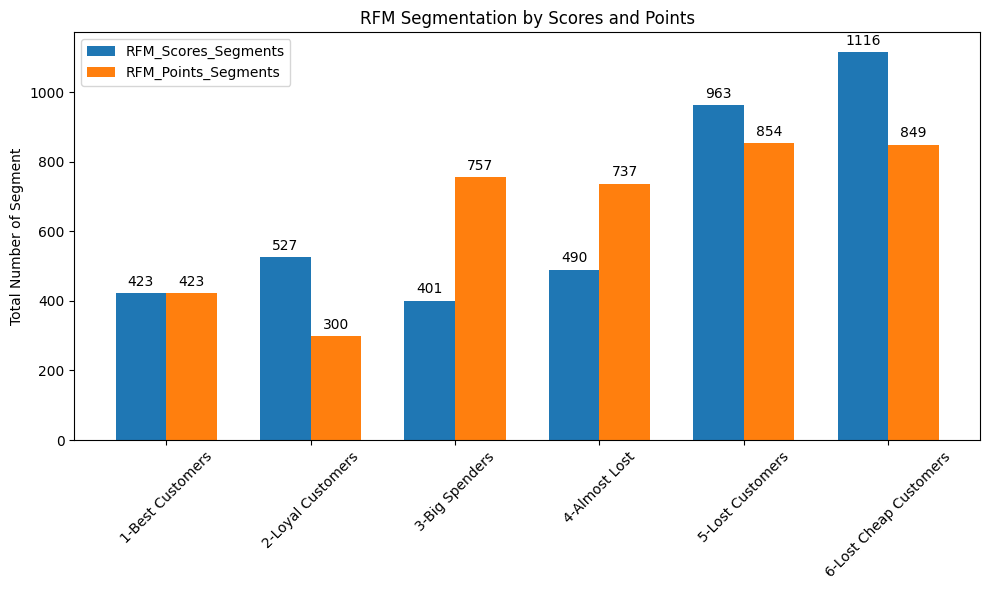

In [92]:
labels = list(df_rfm.RFM_Scores_Segments.value_counts().sort_index().index)
RFM_Scores_Segments = list(df_rfm.RFM_Scores_Segments.value_counts().sort_index().values)
RFM_Points_Segments = list(df_rfm.RFM_Points_Segments.value_counts().sort_index().values)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, RFM_Scores_Segments, width, label='RFM_Scores_Segments')
rects2 = ax.bar(x + width/2, RFM_Points_Segments, width, label='RFM_Points_Segments')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total Number of Segment')
ax.set_title('RFM Segmentation by Scores and Points')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation = 45)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)


fig.tight_layout()

plt.show()


**Explanation:**
* We can say: Distribution of Clustering Based on RFM_Points is more successful. It is closer to normal distribution, even through left skewed.
* We will continue with the visualization of Distribution of Clustering Based on RFM_Points

## Plot RFM Segments

1. Create your plot and resize it.

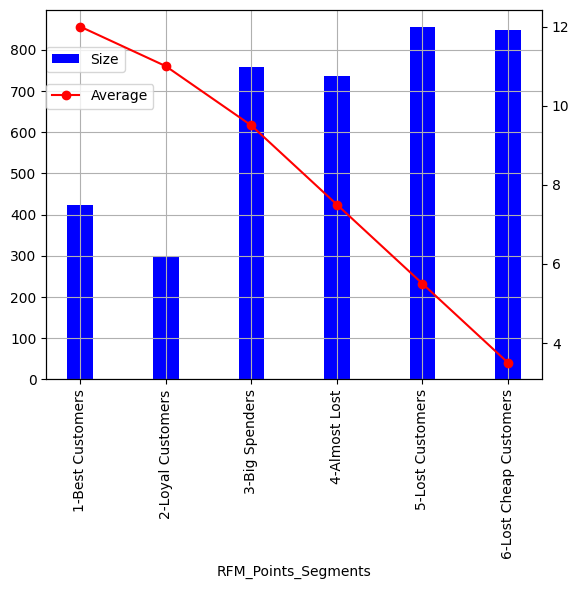

In [95]:
fig, ax = plt.subplots()
summary['count'].plot(ax=ax,color='b',label='Size',kind='bar',width=0.3)
plt.legend(bbox_to_anchor=(0.0, 0.90), loc=2, borderaxespad=0.)

ax2 = ax.twinx()
summary.avg_RFM_Points.plot(ax=ax2,color='r',label='Average', marker='o')
plt.legend(bbox_to_anchor=(0.0, 0.80), loc=2, borderaxespad=0.)
ax.grid()

Using customer segmentation categories found [here](http://www.blastam.com/blog/rfm-analysis-boosts-sales) we can formulate different marketing strategies and approaches for customer engagement for each type of customer.

Note: The author in the article scores 1 as the highest and 4 as the lowest

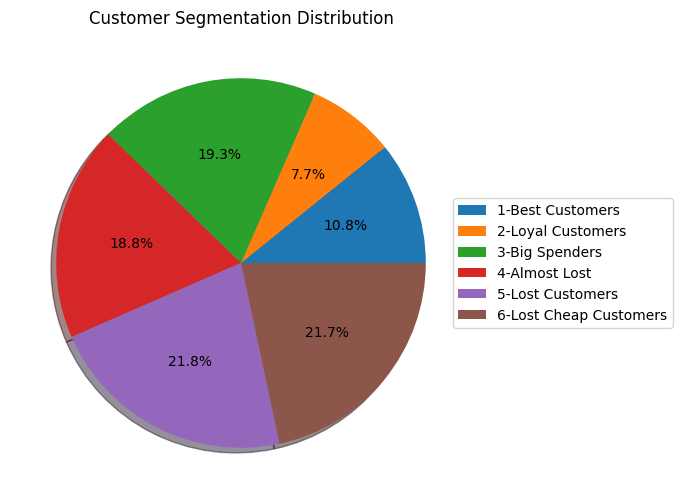

In [96]:
plt.figure(figsize=(6,6))

# explode = [0.01,0.01,0.1]
plt.pie(df_rfm['RFM_Points_Segments'].value_counts().sort_index(),autopct='%1.1f%%',shadow=True,startangle=0)
plt.legend(df_rfm['RFM_Points_Segments'].value_counts().sort_index().index,bbox_to_anchor=(1.45,0.5),loc='center right')
plt.title('Customer Segmentation Distribution')
plt.axis('off')
plt.show()

<Figure size 1500x1500 with 0 Axes>

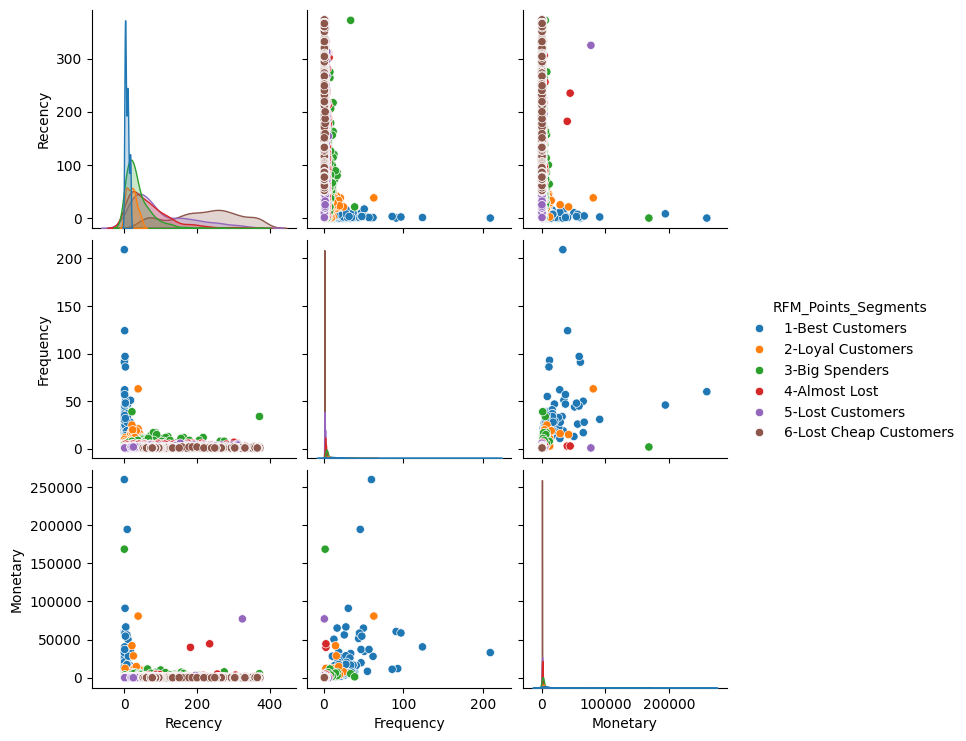

In [97]:
plt.figure(figsize=(15,15))
df_rfm=df_rfm.sort_values('RFM_Points_Segments')
sns.pairplot(df_rfm[['Recency', 'Frequency', 'Monetary','RFM_Points_Segments']],hue='RFM_Points_Segments')

**Explanation:**
* There is no so clear meaningful pattern in this graph. It needs scaling.

<Figure size 2000x2000 with 0 Axes>

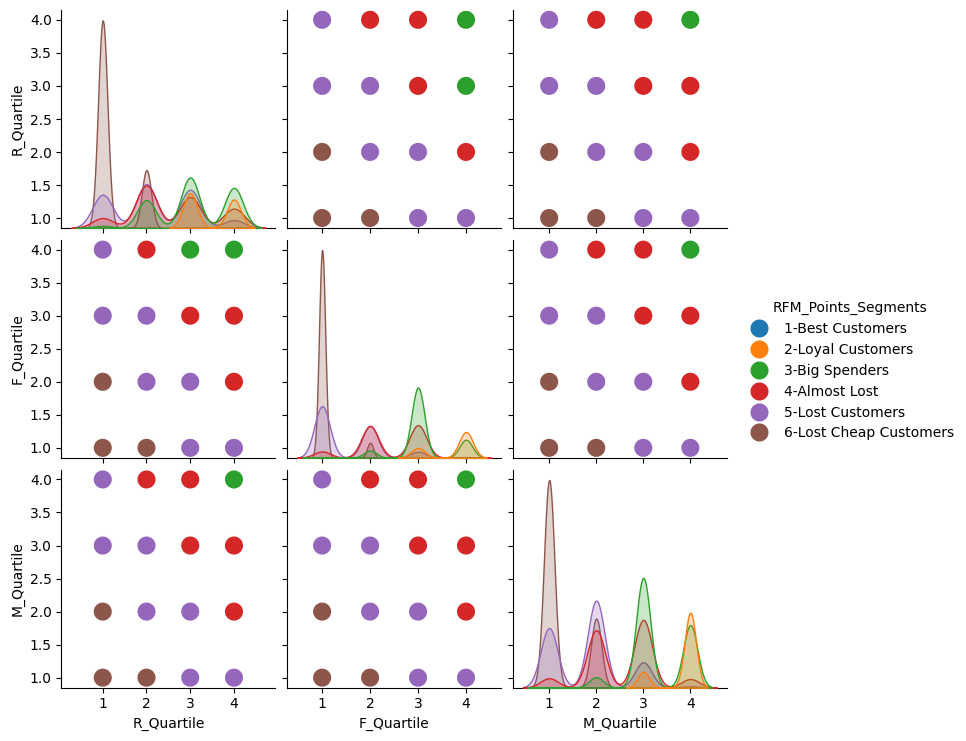

In [98]:
plt.figure(figsize=(20,20))
# df_rfm=df_rfm.sort_values('RFM_Points_Segments')
sns.pairplot(df_rfm[['R_Quartile', 'F_Quartile', 'M_Quartile','RFM_Points_Segments']],
             hue='RFM_Points_Segments',plot_kws={"s": 200})

**Explanations:**
* "1-Best Customers" >> {444}
* "2-Loyal Customers"
* "3-Big Spenders"
* "4-Almost Lost"
* "5-Lost Customers"
* "6-Lost Cheap Customers" >> {111}

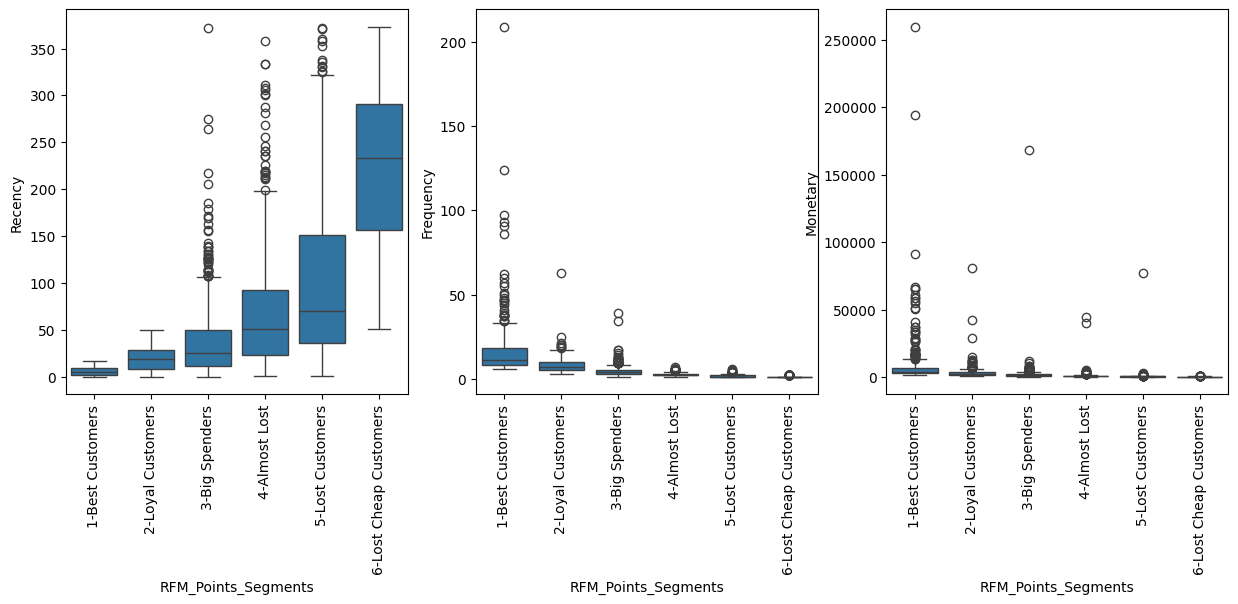

In [103]:
plt.figure(figsize=(15,5))
# df_rfm=df_rfm.sort_values('RFM_Points_Segments')

plt.subplot(1,3,1)
sns.boxplot(x=df_rfm['RFM_Points_Segments'], y=df_rfm['Recency'])
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.boxplot(x=df_rfm['RFM_Points_Segments'], y=df_rfm['Frequency'])
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.boxplot(x=df_rfm['RFM_Points_Segments'], y=df_rfm['Monetary'])
plt.xticks(rotation=90)
plt.show()

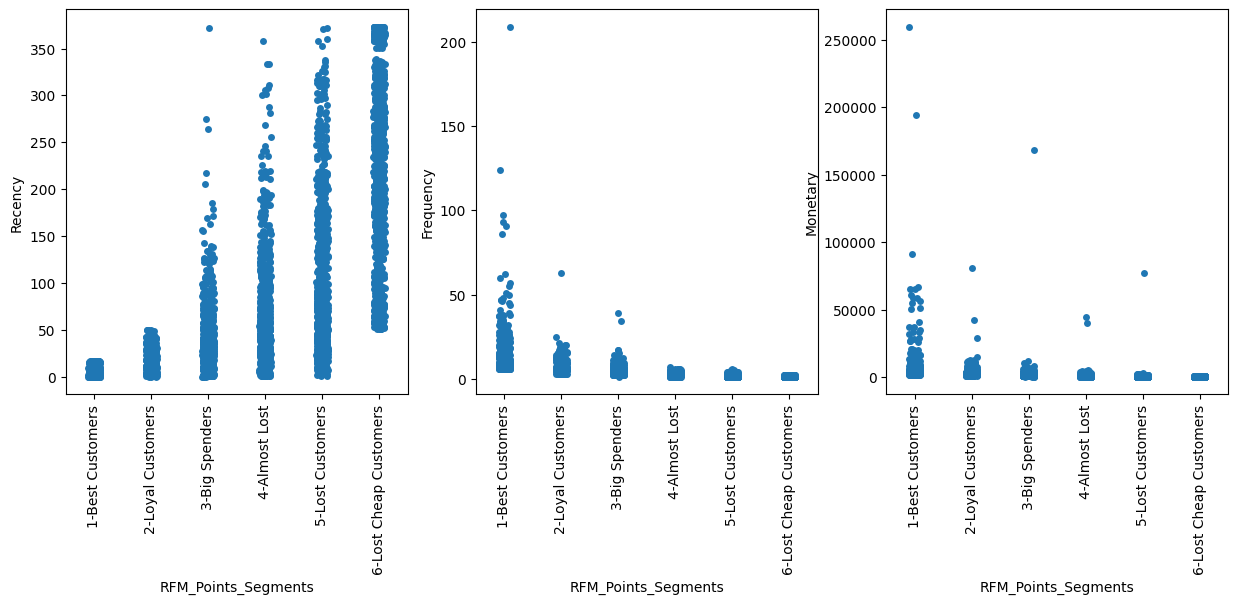

In [104]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.stripplot(x=df_rfm['RFM_Points_Segments'], y=df_rfm['Recency'])
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.stripplot(x=df_rfm['RFM_Points_Segments'], y=df_rfm['Frequency'])
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.stripplot(x=df_rfm['RFM_Points_Segments'], y=df_rfm['Monetary'])
plt.xticks(rotation=90)
plt.show()

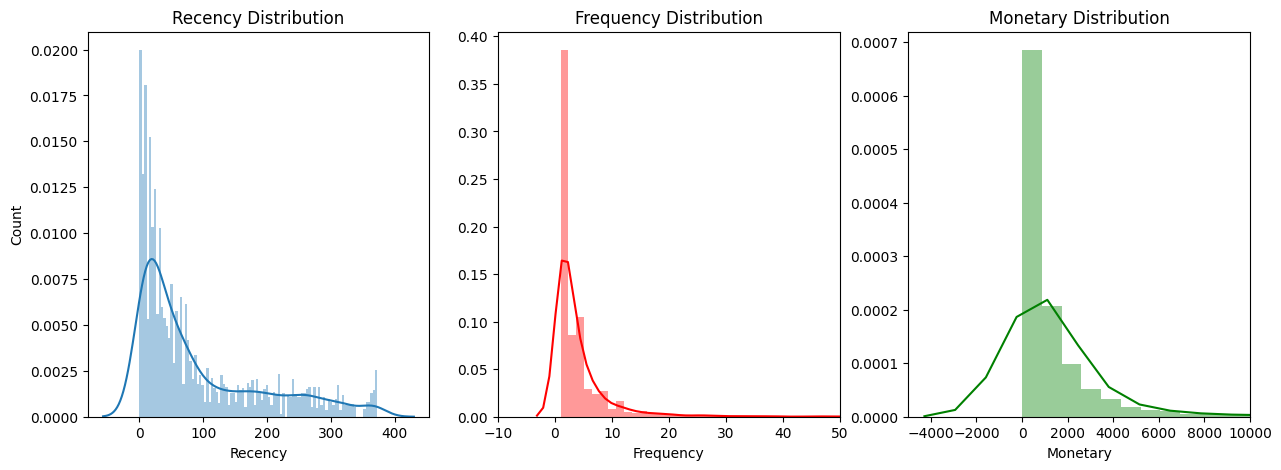

In [105]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.distplot(df_rfm.Recency,bins=100)
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.subplot(1,3,2)
sns.distplot(df_rfm['Frequency'],color='red',bins=150)
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('')
plt.xlim(-10, 50)

plt.subplot(1,3,3)
sns.distplot(df_rfm['Monetary'],color='green',bins=300)
plt.title('Monetary Distribution')
plt.xlabel('Monetary')
plt.ylabel('')
plt.xlim(-5000, 10000)
plt.show()

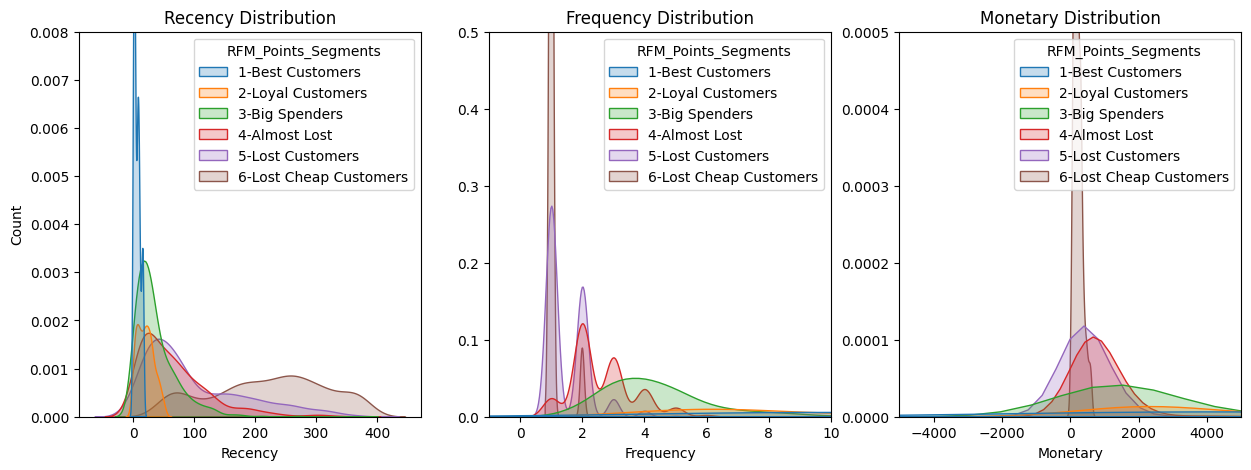

In [106]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.kdeplot(x='Recency',data=df_rfm,hue="RFM_Points_Segments",shade=True)
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')
plt.ylim(0, 0.008)

plt.subplot(1,3,2)
sns.kdeplot(x='Frequency',data=df_rfm,hue="RFM_Points_Segments",shade=True)
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('')
plt.xlim(-1, 10)
plt.ylim(0, 0.5)

plt.subplot(1,3,3)
sns.kdeplot(x='Monetary',data=df_rfm,hue="RFM_Points_Segments",shade=True)
plt.title('Monetary Distribution')
plt.xlabel('Monetary')
plt.ylabel('')
plt.xlim(-5000, 5000)
plt.ylim(0, 0.0005)
plt.show()

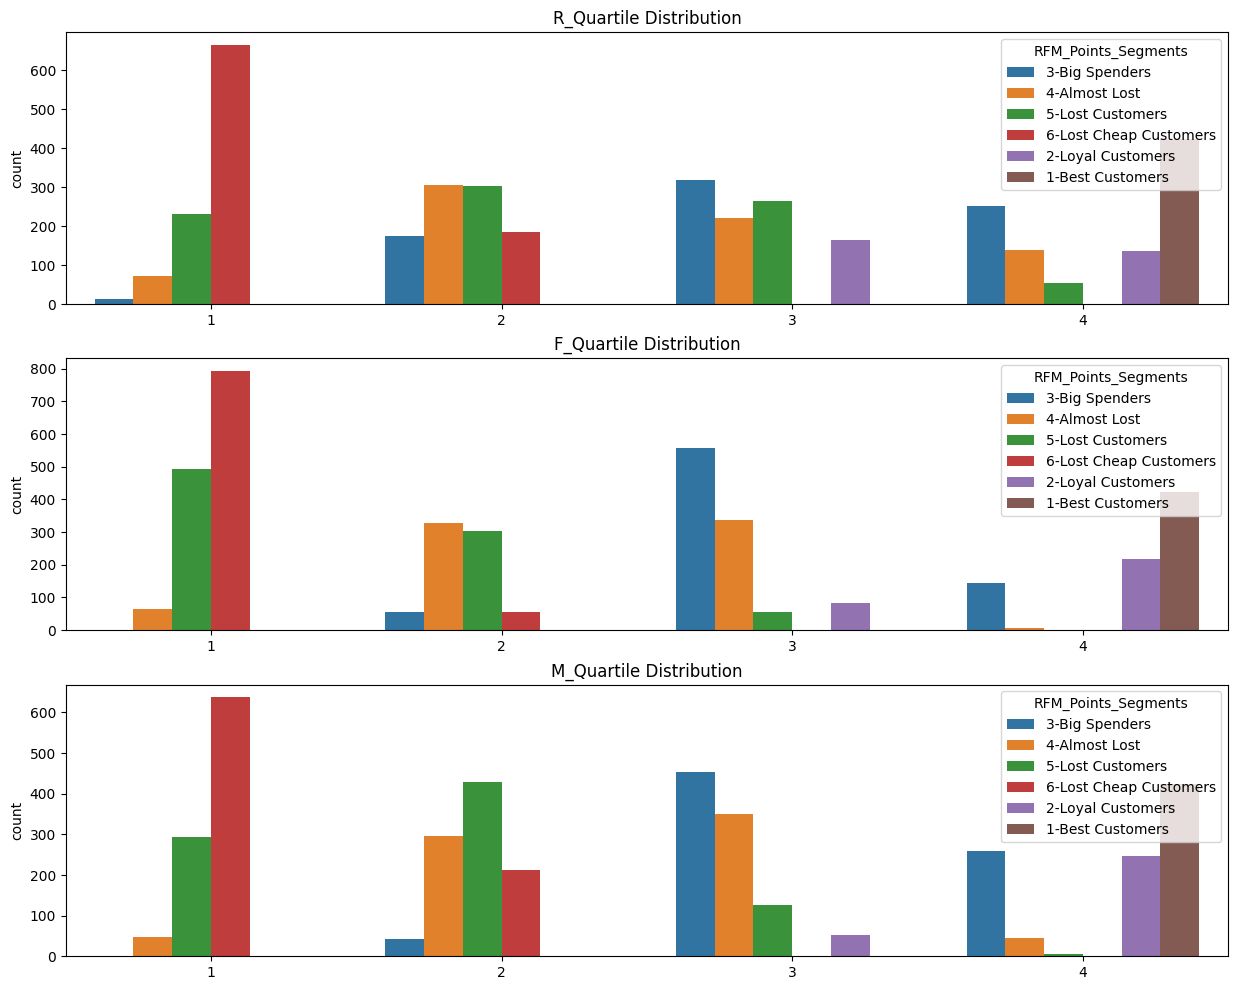

In [107]:
plt.figure(figsize=(15,12))

plt.subplot(3,1,1)
plt.title('R_Quartile Distribution')
sns.countplot(x='R_Quartile', hue='RFM_Points_Segments', data=df_rfm)
plt.xlabel('')

plt.subplot(3,1,2)
plt.title('F_Quartile Distribution')
sns.countplot(x='F_Quartile',  hue='RFM_Points_Segments', data=df_rfm)
plt.xlabel('')

plt.subplot(3,1,3)
plt.title('M_Quartile Distribution')
sns.countplot(x='M_Quartile',  hue='RFM_Points_Segments', data=df_rfm)
plt.xlabel('')
plt.show()

2. How many customers do we have in each segment?

In [108]:
df_rfm.RFM_Points_Segments.value_counts().sort_index()

RFM_Points_Segments
1-Best Customers          423
2-Loyal Customers         300
3-Big Spenders            757
4-Almost Lost             737
5-Lost Customers          854
6-Lost Cheap Customers    849
Name: count, dtype: int64

# 3. Applying K-Means Clustering

Now that we have our customers segmented into 6 different categories, we can gain further insight into customer behavior by using predictive models in conjuction with out RFM model.
Possible algorithms include **Logistic Regression**, **K-means Clustering**, and **K-nearest Neighbor**. We will go with [K-Means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1) since we already have our distinct groups determined. K-means has also been widely used for market segmentation and has the advantage of being simple to implement.

## Data Pre-Processing and Exploring

In [109]:
df_uk.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   

         Date  Recency  Frequency  Monetary  
0  2010-12-01      372         34   5391.21  
1  2010-12-01      372         34   5391.21  
2  2010-12-01      372         34   5391.21  
3  2010-12-01      372         34   5391.21  
4  2010-12-01      372         34   5391.21

In [110]:
df_uk['InvoicePeriod']=pd.to_datetime(df_uk['InvoiceDate']).apply(lambda x: x.to_period('M'))
df_line=pd.DataFrame(df_uk.groupby('InvoicePeriod').CustomerID.nunique())
df_line['TotalPrice']=df_uk.groupby('InvoicePeriod').TotalPrice.sum()

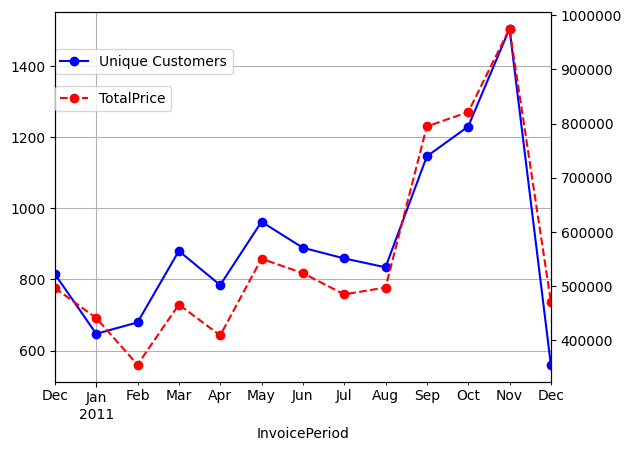

In [111]:
fig, ax = plt.subplots()
df_line.CustomerID.plot(ax=ax,color='b',label='Unique Customers', marker='o')
plt.legend(bbox_to_anchor=(0.0, 0.90), loc=2, borderaxespad=0.)

ax2 = ax.twinx()
df_line.TotalPrice.plot(ax=ax2,color='r',label='TotalPrice',linestyle='--', marker='o')
plt.legend(bbox_to_anchor=(0.0, 0.80), loc=2, borderaxespad=0.)
plt.gcf().axes[1].yaxis.get_major_formatter().set_scientific(False) # remove scientific notation
ax.grid()

Explanation:
It is seen that customer traffic — and therefore total sales — varies for each month. Therefore, we can say that the “lifecycle” of a customer in the system is also a parameter we need to take into consideration.

In [114]:
life_span=pd.DataFrame(df.groupby('CustomerID').InvoiceDate.apply(lambda x:max(x).date() - min(x).date()))
life_span['InvoiceDate'] = life_span['InvoiceDate'].apply(lambda x: x.days)
life_span=life_span.rename(columns= {'InvoiceDate':'life_span'})

In [115]:
df_kmeans=df_rfm[['Recency', 'Frequency', 'Monetary']]
df_kmeans['life_span']=life_span
df_kmeans

Recency  Frequency  Monetary  life_span
13199.0        3         38   9817.12        363
14215.0       11          6   1789.72        357
16076.0        3         10   2234.73        205
17218.0        4         10   1951.97        364
17519.0       17          6   1844.02        351
...          ...        ...       ...        ...
14924.0      245          1    310.05          0
15119.0      245          1    266.40          0
16643.0      245          1    487.51          0
17746.0      240          1    110.25          0
18185.0      249          1    304.25          0

[3920 rows x 4 columns]

Create Heatmap and evaluate the results

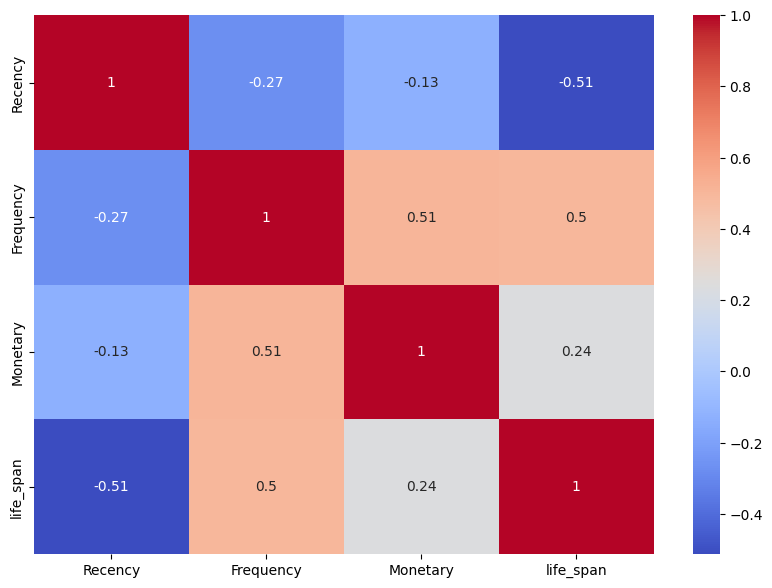

In [116]:
plt.figure(figsize=(10,7))
sns.heatmap(df_kmeans.corr(),annot=True, cmap="coolwarm");

### ii. Visualize Feature Distributions

To get a better understanding of the dataset, you can costruct a scatter matrix of each of the three features in the RFM data.

### iii. Data Normalization

1. You can use the logarithm method to normalize the values in a column.

In [117]:
def col_plot(df,col_name,iqr=1.5):
    plt.figure(figsize=(15,5))

    plt.subplot(141) # 1 satir x 4 sutun dan olusan ax in 1. sutununda calis
    plt.hist(df[col_name], bins = 20)
    f=lambda x:(np.sqrt(x) if x>=0 else -np.sqrt(-x))

    # üç sigma aralikta(verinin %99.7 sini icine almasi beklenen bolum) iki kirmizi cizgi arasinda
    plt.axvline(x=df[col_name].mean() + 3*df[col_name].std(),color='red')
    plt.axvline(x=df[col_name].mean() - 3*df[col_name].std(),color='red')
    plt.xlabel(col_name)
    plt.tight_layout
    plt.xlabel("Histogram ±3z")
    plt.ylabel(col_name)

    plt.subplot(142)
    plt.boxplot(df[col_name], whis = iqr)
    plt.xlabel(f"IQR={iqr}")

    plt.subplot(143)
    plt.boxplot(df[col_name].apply(f), whis = iqr)
    plt.xlabel(f"ROOT SQUARE - IQR={iqr}")

    plt.subplot(144)
    plt.boxplot(np.log(df[col_name]+1), whis = iqr)
    plt.xlabel(f"LOGARITMIC - IQR={iqr}")
    plt.show()

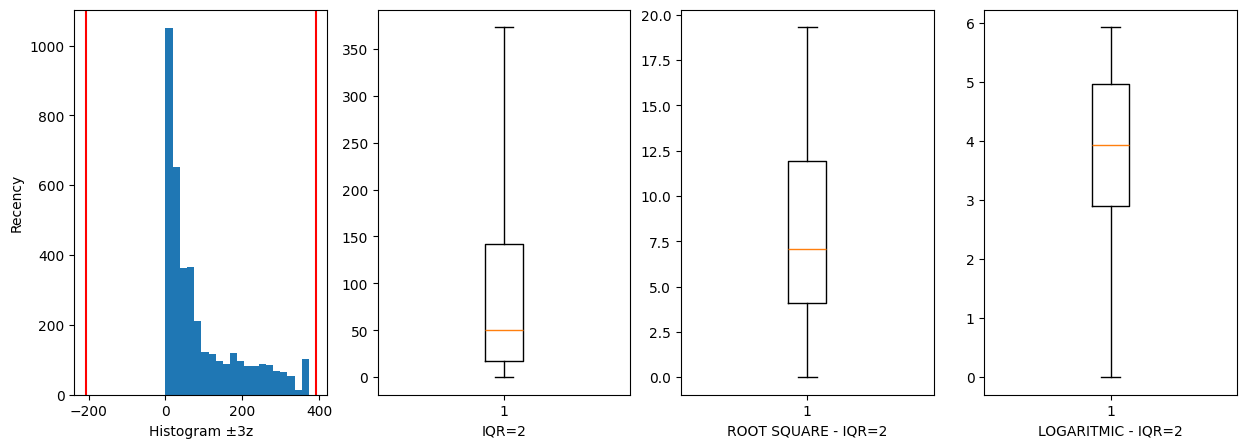

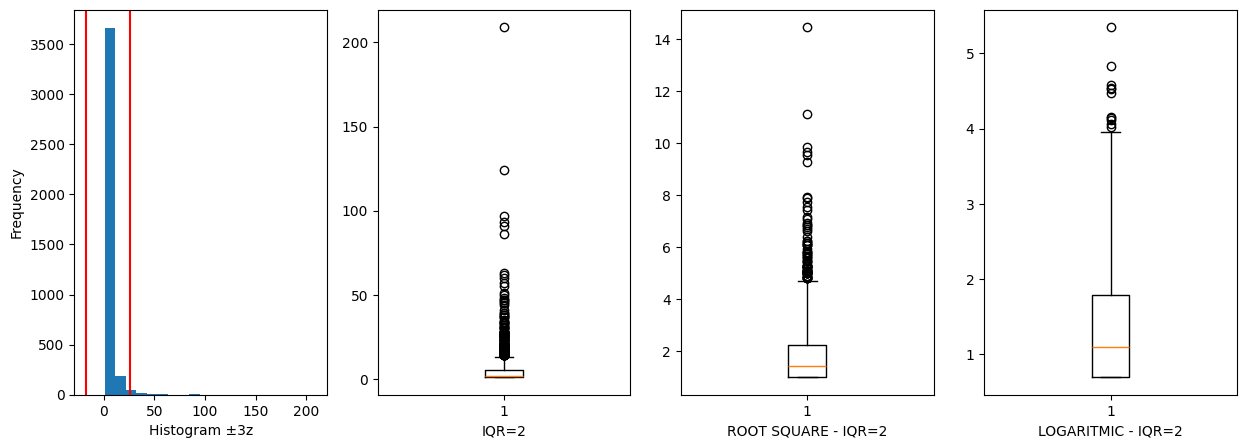

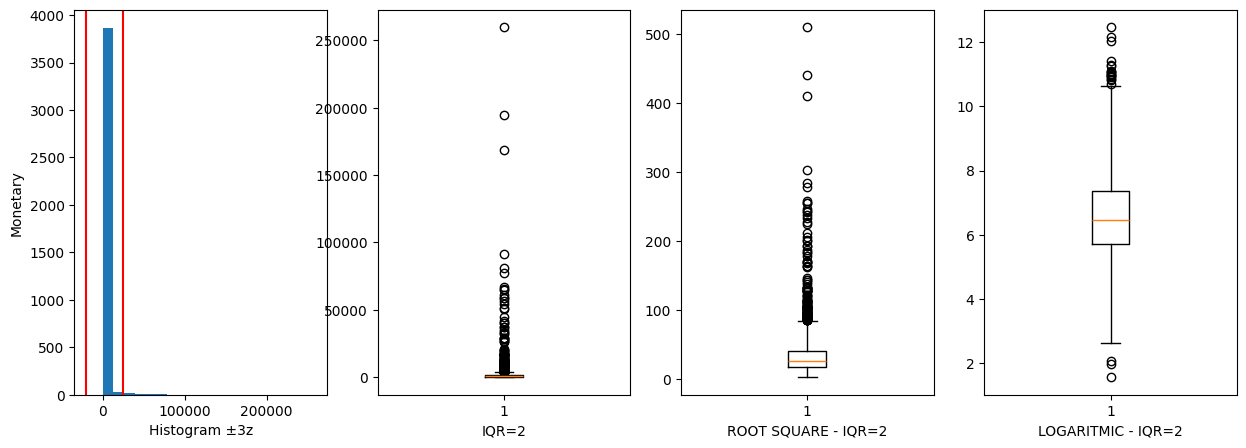

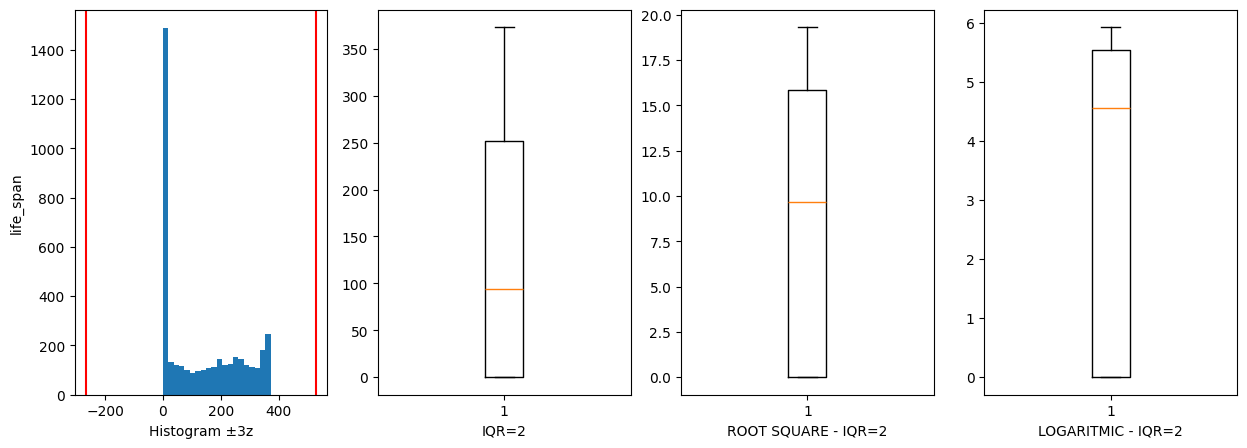

In [118]:
for i in df_kmeans:
    col_plot(df_kmeans,i,2)

In [119]:
features=[
#           'Recency',
          'Frequency',
          'Monetary',
#           'life_span',
         ]

In [120]:
df_log=df_kmeans.copy()
for i in features:
    df_log[i]=np.log(df_log[i]+1)

In [121]:
def detect_outliers(df:pd.DataFrame, col_name:str, p=1.5) ->int:
    '''
    this function detects outliers based on 3 time IQR and
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile

    upper_limit = third_quartile+(p*IQR)
    lower_limit = first_quartile-(p*IQR)
    outlier_count = 0

    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

**Outlier Detection**

In [122]:
iqr=2
print(f"Number of Outliers for {iqr}*IQR after Logarithmed\n")

total=0
for col in features:
    if detect_outliers(df_log, col)[2] > 0:
        outliers=detect_outliers(df_log, col, iqr)[2]
        total+=outliers
        print("{} outliers in '{}'".format(outliers,col))
print("\n{} OUTLIERS TOTALLY".format(total))

Number of Outliers for 2*IQR after Logarithmed

11 outliers in 'Frequency'
20 outliers in 'Monetary'

31 OUTLIERS TOTALLY


**Drop Outliers**

In [123]:
df_log.shape

(3920, 4)

In [124]:
iqr=2
for i in ['Frequency','Monetary']:
    lower,upper,_=detect_outliers(df_log,i,iqr)
    df_log=df_log[(df_log[i]>lower)&(df_log[i]<upper)]

In [125]:
df_log.shape

(3893, 4)

**Explanation**
* If you have binary values, discrete attributes or categorial attributes, stay away from k-means. K-means needs to compute means, and the mean value is not meaningful on this kind of data.

**Scaling:**
* If you have attributes with a well-defined meaning. Say, latitude and longitude, then you should not scale your data, because this will cause distortion.

* If you have mixed numerical data, where each attribute is something entirely different (say, shoe size and weight), has different units attached (lb, tons, m, kg ...) then these values aren't really comparable anyway;scaling them is a best-practise to give equal weight to them.

In [126]:
from sklearn.preprocessing import StandardScaler

df_scaled = pd.DataFrame(StandardScaler().fit_transform(df_log),
                         columns=df_kmeans.columns,index=df_log.index)
df_scaled.head()

Recency  Frequency  Monetary  life_span
13199.0 -0.895600   3.561350  2.242316   1.766146
14215.0 -0.815192   0.936915  0.815602   1.720610
16076.0 -0.895600   1.627513  1.001695   0.567049
17218.0 -0.885549   1.627513  0.888323   1.773735
17519.0 -0.754886   0.936915  0.840648   1.675075

2. Plot normalized data with scatter matrix or pairplot. Also evaluate results.

<Figure size 1500x1500 with 0 Axes>

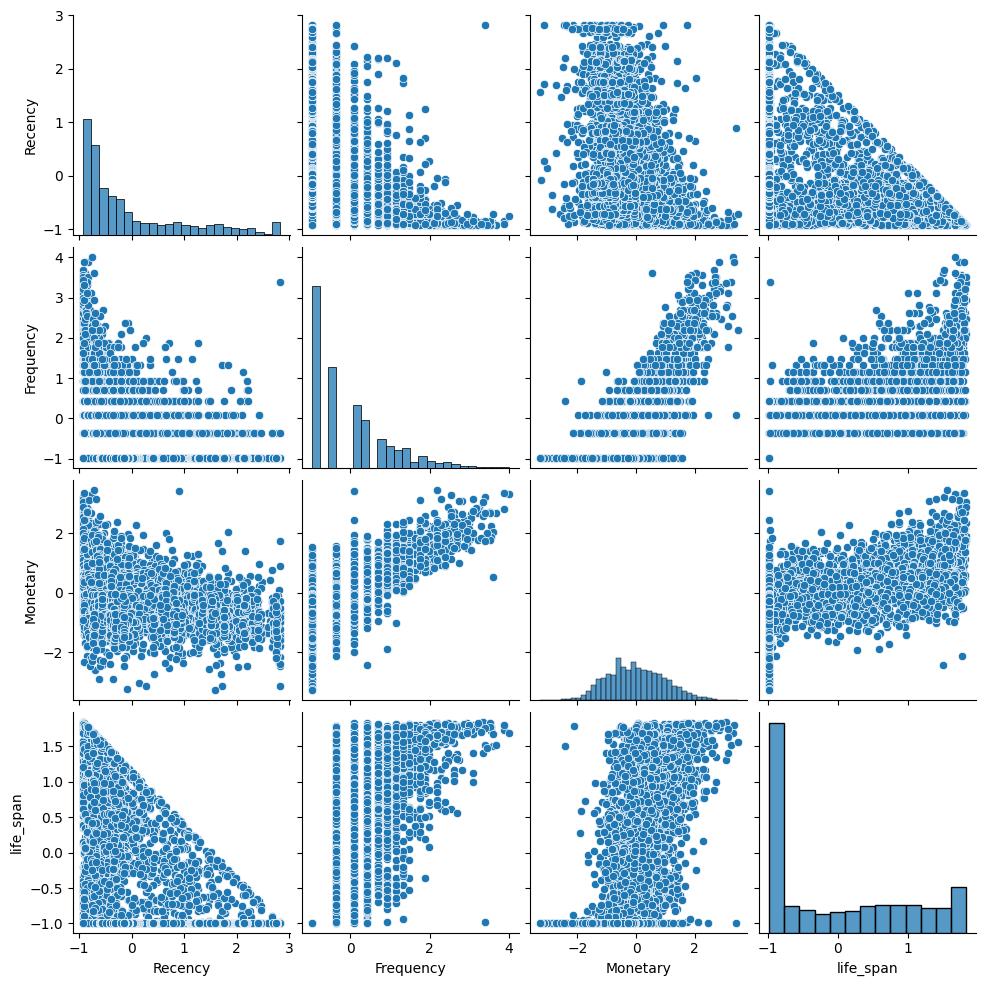

In [127]:
plt.figure(figsize=(15,15))
sns.pairplot(df_scaled[['Recency', 'Frequency', 'Monetary','life_span']]);

## K-Means Implementation

For k-means, you have to set k to the number of clusters you want, but figuring out how many clusters is not obvious from the beginning. We will try different cluster numbers and check their [silhouette coefficient](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html). The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar).
<br>
<br>
**Note**: K-means is sensitive to initializations because they are critical to qualifty of optima found. Thus, we will use smart initialization called "Elbow Method".

### i. Define the Optimal Number of Clusters

In [128]:
!pip install pyclustertend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 103.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [129]:
from sklearn.cluster import KMeans
from pyclustertend import hopkins
from sklearn.metrics import silhouette_score

Hopkins Test

It is based on the Null Hypothesis (H₀) and the Alternative Hypothesis (Hₐ).

Null Hypothesis (H₀): The data has a uniform distribution; there is no significant clustering.

Alternative Hypothesis (Hₐ): The data consists of random data points, meaning there is clustering.

It gives a score in the range [0, 1]. As the score approaches 0, the data is not uniform — in other words, it tends to cluster.

As the score approaches 1, the data has a uniform structure. If the score does not exceed 0.5, the data is considered clusterable. In practice, 0.3 is taken as the threshold.

In [130]:
hopkins(df_scaled,df_scaled.shape[0])

np.float64(0.08575336793936465)

**Evaluations:**
* According to Hopkins Score, we can say our dataframe tends to clustering too much.

[The Elbow Method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)
It is a method that develops a solution based on the relationship between explained variance (sum of squared distances) and the number of clusters (k). In other words, explained variance is plotted as a function of the number of clusters, and the point where the “elbow” breaks in the graph is the optimal value of k.
We will take the optimal point where the smallest k corresponds to the minimum error. In other words, we choose the point where the sharp decrease ends.

In [131]:
ssd = []
K = range(2,10)
for k in K:
    kmeans = KMeans(n_clusters = k).fit((df_scaled))
    ssd.append(kmeans.inertia_)

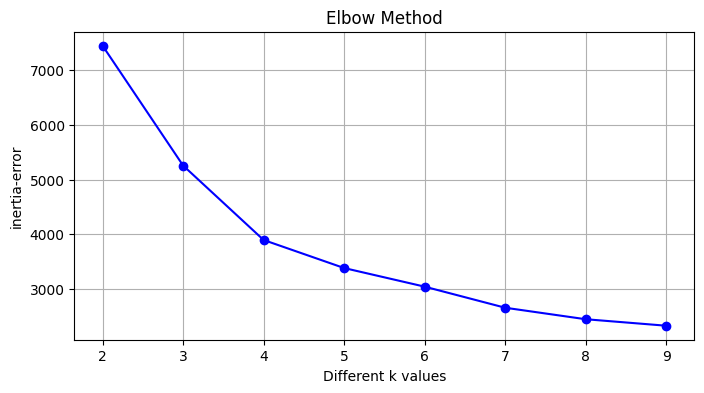

In [132]:
plt.figure(figsize=(8,4))
plt.plot(K, ssd, "bo-")
plt.xlabel("Different k values")
plt.ylabel("inertia-error")
plt.title("Elbow Method")
plt.grid()
plt.show()

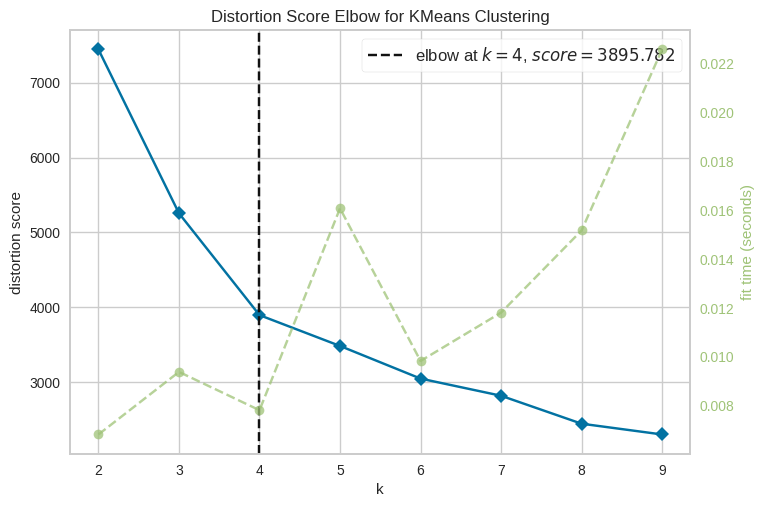

In [133]:
from yellowbrick.cluster import KElbowVisualizer
kmeans = KMeans()
visu = KElbowVisualizer(kmeans, k = (2,10))
visu.fit(df_scaled)
visu.show();

[Silhouette Coefficient](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
It is based on two distances for each data point.
The first distance is the average distance between the data point and the other points within the same cluster.
The second distance is the average distance between the data point and all points in the nearest neighboring cluster.

It is expressed by the value s.
If s is close to 1, it indicates strong clustering;
if it is close to -1, it indicates weak or incorrect clustering.

### ii. Model Fitting

Fit the K-Means Algorithm with the optimal number of clusters you decided and save the model to disk.

In [134]:
kmeans = KMeans(n_clusters = 4).fit(df_scaled)
labels = kmeans.labels_
df_scaled['Kmeans_Label_ID']=labels

In [135]:
keys=df_scaled.groupby('Kmeans_Label_ID').Frequency.mean().sort_values().index
values=['Bronze','Silver','Gold','Diamond']
dictionary = dict(zip(keys, values))

df_scaled['Kmeans_Label']=df_scaled.Kmeans_Label_ID.apply(lambda x:dictionary[x] )
df_scaled

Recency  Frequency  Monetary  life_span  Kmeans_Label_ID  \
13199.0 -0.895600   3.561350  2.242316   1.766146                2   
14215.0 -0.815192   0.936915  0.815602   1.720610                2   
16076.0 -0.895600   1.627513  1.001695   0.567049                2   
17218.0 -0.885549   1.627513  0.888323   1.773735                2   
17519.0 -0.754886   0.936915  0.840648   1.675075                2   
...           ...        ...       ...        ...              ...   
14924.0  1.536749  -0.977207 -0.652035  -0.988741                3   
15119.0  1.536749  -0.977207 -0.778815  -0.988741                3   
16643.0  1.536749  -0.977207 -0.273554  -0.988741                3   
17746.0  1.486494  -0.977207 -1.514106  -0.988741                3   
18185.0  1.576953  -0.977207 -0.667817  -0.988741                3   

        Kmeans_Label  
13199.0      Diamond  
14215.0      Diamond  
16076.0      Diamond  
17218.0      Diamond  
17519.0      Diamond  
...              ...  
14924.0       Bronze  
15119.0       Bronze  
16643.0       Bronze  
17746.0       Bronze  
18185.0       Bronze  

[3893 rows x 6 columns]

### iii. Visualize the Clusters

1. Create a scatter plot and select cluster centers

In [136]:
df_scaled.Kmeans_Label.value_counts().sort_index()

Kmeans_Label
Bronze      828
Diamond     671
Gold       1286
Silver     1108
Name: count, dtype: int64

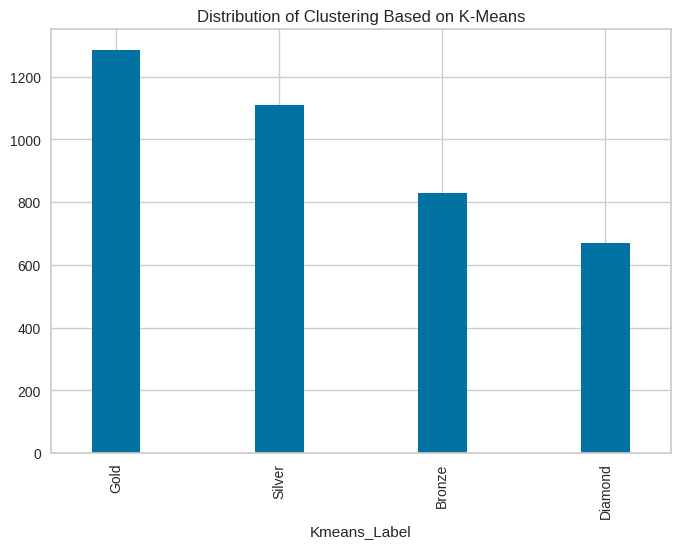

In [137]:
df_scaled.Kmeans_Label.value_counts().plot.bar(width=0.3)
plt.title('Distribution of Clustering Based on K-Means');

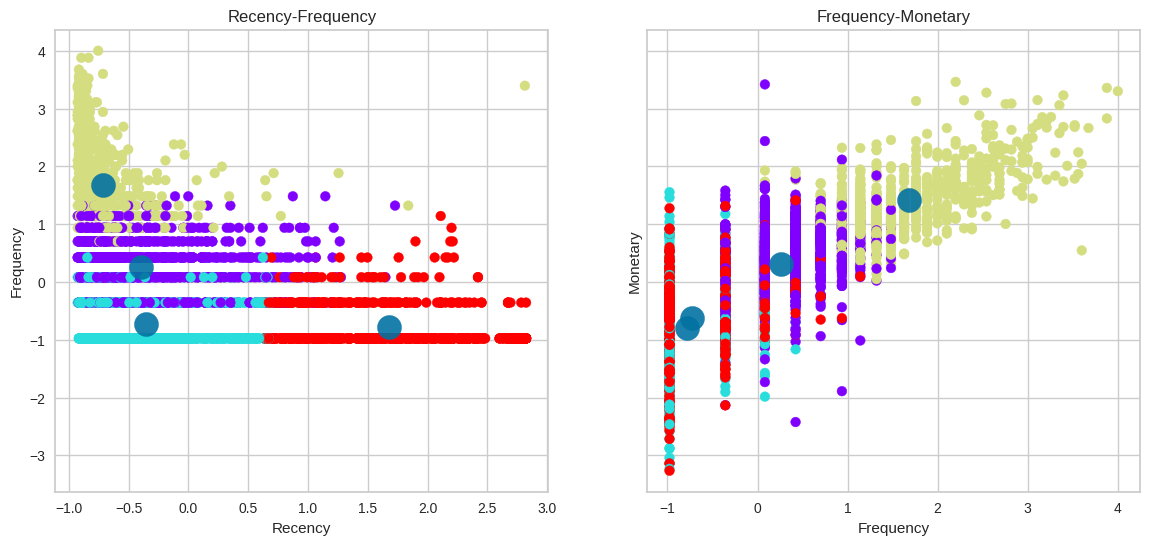

In [138]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(14,6)) # sharey=True ile y eksen labels lari ortak kullanirlar.
ax1.set_title('Recency-Frequency')
ax1.set_xlabel('Recency')
ax1.set_ylabel('Frequency')
ax1.scatter(df_scaled.iloc[:,0],df_scaled.iloc[:,1],c=kmeans.labels_,cmap="rainbow")
ax1.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300,alpha=0.9, label = 'Centroids')

ax2.set_title("Frequency-Monetary")
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Monetary')
ax2.scatter(df_scaled.iloc[:,1],df_scaled.iloc[:,2],c=kmeans.labels_,cmap="rainbow")
ax2.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], s=300,alpha=0.9, label = 'Centroids');


<Figure size 1500x1500 with 0 Axes>

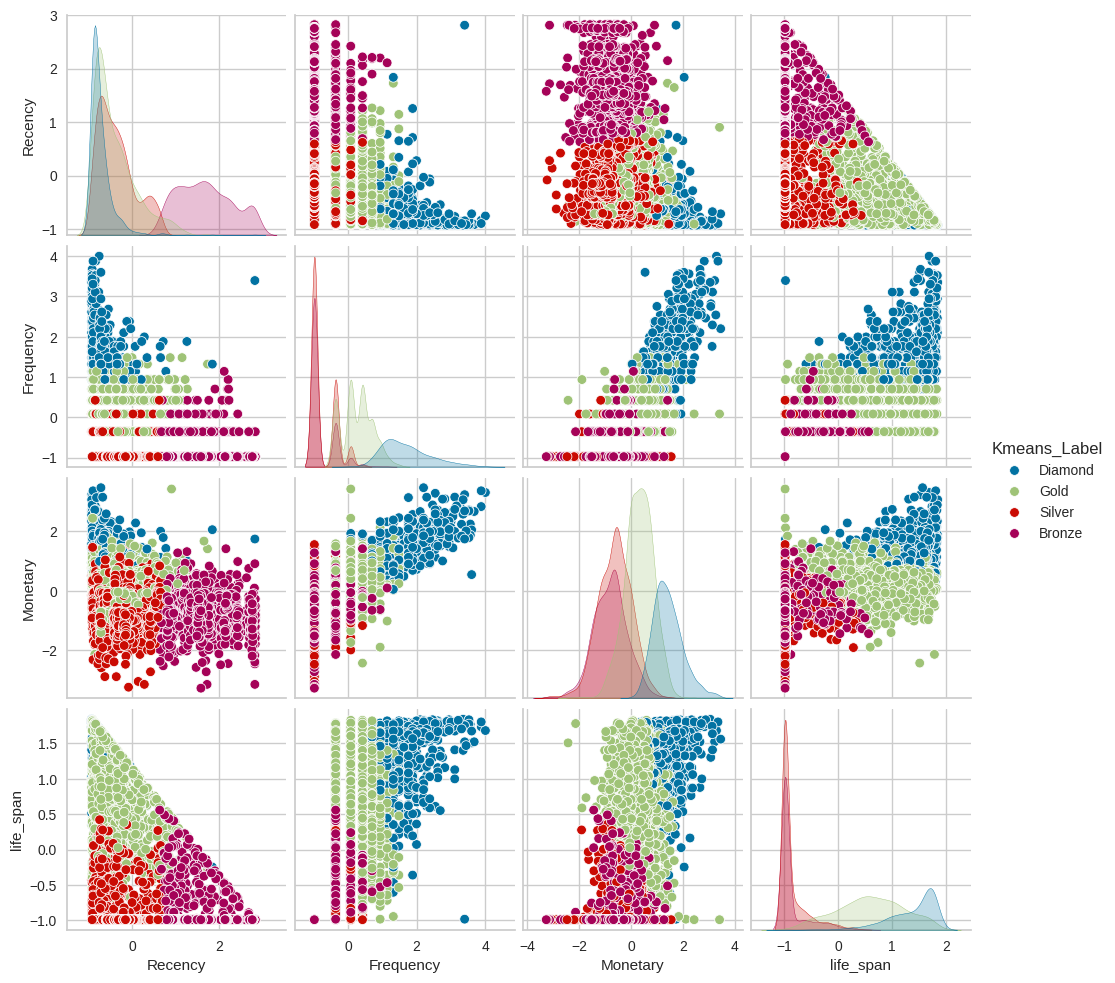

In [139]:
plt.figure(figsize=(15,15))
sns.pairplot(df_scaled[['Recency', 'Frequency', 'Monetary','life_span','Kmeans_Label']],hue='Kmeans_Label');

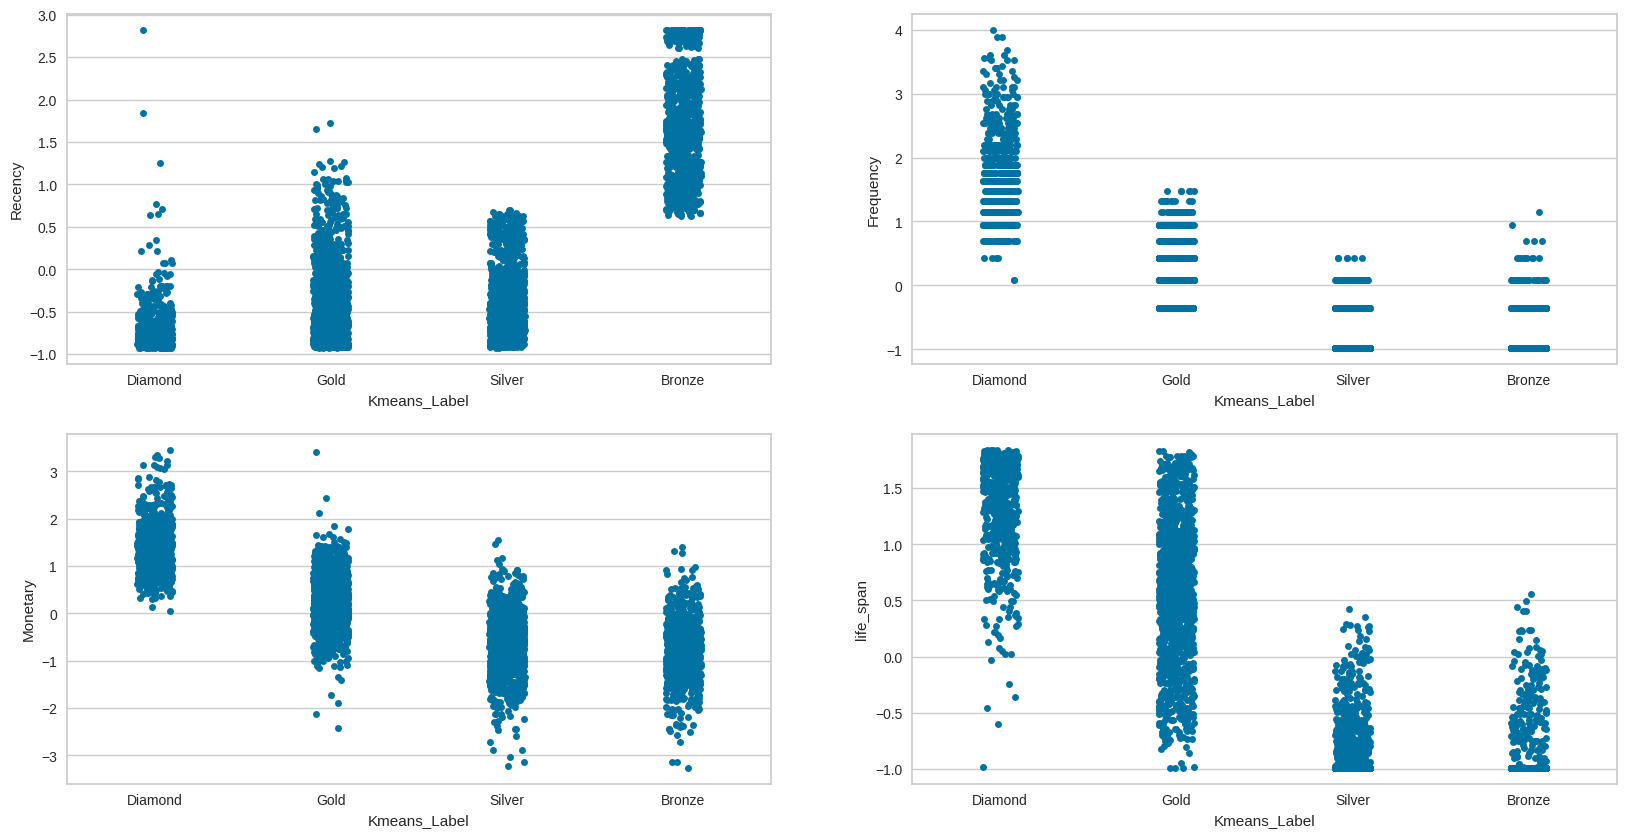

In [141]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
sns.stripplot(x=df_scaled['Kmeans_Label'], y=df_scaled['Recency'])

plt.subplot(2,2,2)
sns.stripplot(x=df_scaled['Kmeans_Label'], y=df_scaled['Frequency'])

plt.subplot(2,2,3)
sns.stripplot(x=df_scaled['Kmeans_Label'], y=df_scaled['Monetary'])

plt.subplot(2,2,4)
sns.stripplot(x=df_scaled['Kmeans_Label'], y=df_scaled['life_span'])
plt.show()

2. Visualize Cluster Id vs Recency, Cluster Id vs Frequency and Cluster Id vs Monetary using Box plot. Also evaluate the results.

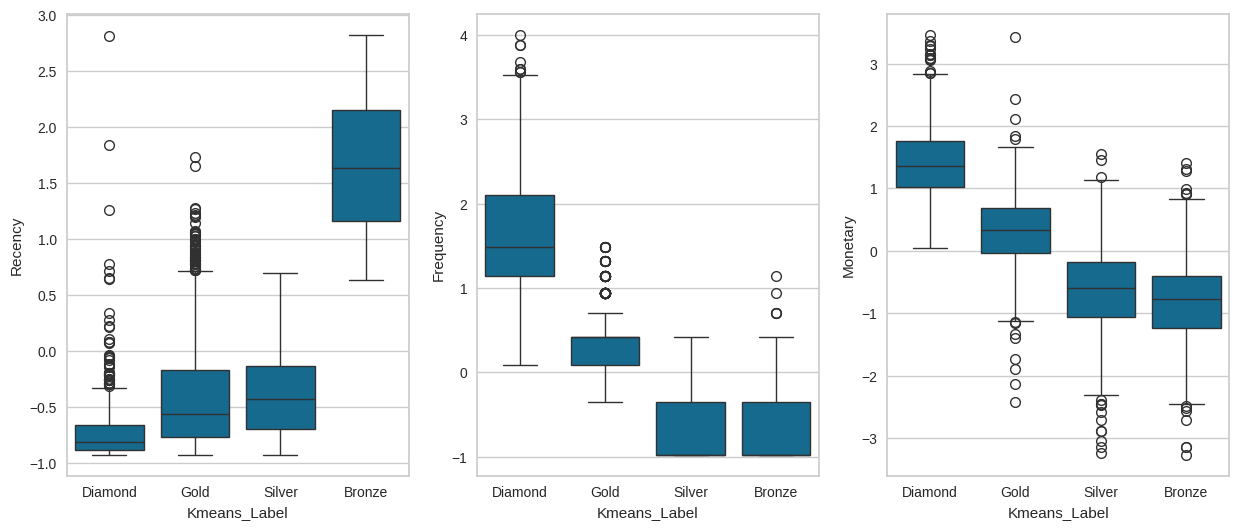

In [143]:
plt.figure(figsize=(15,6))

plt.subplot(1,3,1)
sns.boxplot(x=df_scaled['Kmeans_Label'], y=df_scaled['Recency'])

plt.subplot(1,3,2)
sns.boxplot(x=df_scaled['Kmeans_Label'], y=df_scaled['Frequency'])

plt.subplot(1,3,3)
sns.boxplot(x=df_scaled['Kmeans_Label'], y=df_scaled['Monetary'])
plt.show()

### iv. Assign the Label

**Conclusion**


### v. Conclusion

Discuss your final results. Compare your own labels from the Customer Segmentation with the labels found by K-Means.

How we want to continue this analysis depends on how the business plans to use the results and the level of granularity the business stakeholders want to see in the clusters. We can also ask what range of customer behavior from high to low value customers are the stakeholders interested in exploring. From those answers, various methods of clustering can be used and applied on RFM variable or directly on the transaction data set.

In [144]:
RFM_Points_Segments=['1-Best Customers','2-Loyal Customers', '3-Big Spenders', '4-Almost Lost', '5-Lost Customers', '6-Lost Cheap Customers']
Kmeans_Label=['Diamond','Gold', 'Silver', 'Bronze']
pd.crosstab(df_scaled['Kmeans_Label'],df_rfm['RFM_Points_Segments'])[RFM_Points_Segments].loc[Kmeans_Label]

RFM_Points_Segments  1-Best Customers  2-Loyal Customers  3-Big Spenders  \
Kmeans_Label                                                               
Diamond                           374                200              97   
Gold                               29                 99             589   
Silver                              0                  0              70   
Bronze                              0                  0               0   

RFM_Points_Segments  4-Almost Lost  5-Lost Customers  6-Lost Cheap Customers  
Kmeans_Label                                                                  
Diamond                          0                 0                       0  
Gold                           455               114                       0  
Silver                         258               572                     208  
Bronze                          23               166                     639

**Annotation:**

Limitations of K-means clustering:

1. There is no assurance that it will lead to the global best solution.
2. Can't deal with different shapes(not circular) and consider one point's probability of belonging to more than one cluster.

These disadvantages of K-means show that for many datasets (especially low-dimensional datasets), it may not perform as well as you might hope.

# 5. Create Cohort & Conduct Cohort Analysis
[Cohort Analysis](https://medium.com/swlh/cohort-analysis-using-python-and-pandas-d2a60f4d0a4d) is specifically useful in analyzing user growth patterns for products. In terms of a product, a cohort can be a group of people with the same sign-up date, the same usage starts month/date, or the same traffic source.
Cohort analysis is an analytics method by which these groups can be tracked over time for finding key insights. This analysis can further be used to do customer segmentation and track metrics like retention, churn, and lifetime value.

For e-commerce organizations, cohort analysis is a unique opportunity to find out which clients are the most valuable to their business. by performing Cohort analysis you can get the following answers to the following questions:

- How much effective was a marketing campaign held in a particular time period?
- Did the strategy employ to improve the conversion rates of Customers worked?
- Should I focus more on retention rather than acquiring new customers?
- Are my customer nurturing strategies effective?
- Which marketing channels bring me the best results?
- Is there a seasonality pattern in Customer behavior?
- Along with various performance measures/metrics for your organization.

Since we will be performing Cohort Analysis based on transaction records of customers, the columns we will be dealing with mainly:
- Invoice Data
- CustomerID
- Price
- Quantity

The following steps will performed to generate the Cohort Chart of Retention Rate:
- Month Extraction from InvioceDate column
- Assigning Cohort to Each Transaction
- Assigning Cohort Index to each transaction
- Calculating number of unique customers in each Group of (ChortDate,Index)
- Creating Cohort Table for Retention Rate
- Creating the Cohort Chart using the Cohort Table

The Detailed information about each step is given below:

## Feature Engineering

### i. Extract the Month of the Purchase
First we will create a function, which takes any date and returns the formatted date with day value as 1st of the same month and Year.

In [145]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.head(2)

InvoiceNo StockCode                         Description  Quantity  \
0    536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                 WHITE METAL LANTERN         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34

In [146]:
def extract_ym(df):
    # Extract year and month from the the column. strftim convert datetime to string
    return df.apply(lambda x: x.strftime('%Y-%m')).astype('datetime64[ns]')

Now we will use the function created above to convert all the invoice dates into respective month date format.

In [147]:
extract_ym(df.InvoiceDate)

0        2010-12-01
1        2010-12-01
2        2010-12-01
3        2010-12-01
4        2010-12-01
            ...    
541904   2011-12-01
541905   2011-12-01
541906   2011-12-01
541907   2011-12-01
541908   2011-12-01
Name: InvoiceDate, Length: 392692, dtype: datetime64[ns]

In [148]:
# Alternative
f=lambda x:pd.to_datetime(x).dt.to_period('M')
f(df['InvoiceDate'])

0         2010-12
1         2010-12
2         2010-12
3         2010-12
4         2010-12
           ...   
541904    2011-12
541905    2011-12
541906    2011-12
541907    2011-12
541908    2011-12
Name: InvoiceDate, Length: 392692, dtype: period[M]

### ii. Calculating time offset in Months i.e. Cohort Index:
Calculating time offset for each transaction will allows us to report the metrics for each cohort in a comparable fashion.
First, you will create 4 variables that capture the integer value of years, months for Invoice and Cohort Date using the get_date_int() function which you'll create it below.

In [149]:
def get_date_int(df, column):
    years = df[column].dt.year
    months = df[column].dt.month
    return years, months

You will use this function to extract the integer values for Invoice as well as Cohort Date in 3 seperate series for each of the two columns

In [ ]:
# Alternative
# df['InvoiceMonth']=extract_ym(df.InvoiceDate)

In [150]:
# Apply function to invoice date to invoice month column
df['InvoiceMonth'] = df['InvoiceDate'].apply(lambda x: dt(x.year, x.month, 1) )
df['cohort_date'] = df.groupby('CustomerID')['InvoiceMonth'].transform('min')

In [151]:
cohort_year, cohort_month = get_date_int(df, 'cohort_date')
invoice_year, invoice_month = get_date_int(df, 'InvoiceDate')

Use the variables created above to calcualte the difference in days and store them in cohort Index column.

In [152]:
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

## Create 1st Cohort: User number & Retention Rate

### i. Pivot Cohort and Cohort Retention

In [153]:
df['CohortIndex'] = years_diff * 12 + months_diff + 1
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   

  InvoiceMonth cohort_date  CohortIndex  
0   2010-12-01  2010-12-01            1  
1   2010-12-01  2010-12-01            1  
2   2010-12-01  2010-12-01            1  
3   2010-12-01  2010-12-01            1  
4   2010-12-01  2010-12-01            1

In [154]:
# Count monthly active customers from each cohort
grouping_count = df.groupby(['cohort_date', 'CohortIndex'])
cohort_data = grouping_count['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='cohort_date',
                                  columns='CohortIndex',
                                  values='CustomerID')
cohort_counts

CohortIndex     1      2      3      4      5      6      7      8      9   \
cohort_date                                                                  
2010-12-01   885.0  324.0  286.0  340.0  321.0  352.0  321.0  309.0  313.0   
2011-01-01   417.0   92.0  111.0   96.0  134.0  120.0  103.0  101.0  125.0   
2011-02-01   380.0   71.0   71.0  108.0  103.0   94.0   96.0  106.0   94.0   
2011-03-01   452.0   68.0  114.0   90.0  101.0   76.0  121.0  104.0  126.0   
2011-04-01   300.0   64.0   61.0   63.0   59.0   68.0   65.0   78.0   22.0   
2011-05-01   284.0   54.0   49.0   49.0   59.0   66.0   75.0   27.0    NaN   
2011-06-01   242.0   42.0   38.0   64.0   56.0   81.0   23.0    NaN    NaN   
2011-07-01   188.0   34.0   39.0   42.0   51.0   21.0    NaN    NaN    NaN   
2011-08-01   169.0   35.0   42.0   41.0   21.0    NaN    NaN    NaN    NaN   
2011-09-01   299.0   70.0   90.0   34.0    NaN    NaN    NaN    NaN    NaN   
2011-10-01   358.0   86.0   41.0    NaN    NaN    NaN    NaN    NaN    NaN   
2011-11-01   323.0   36.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-12-01    41.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

CohortIndex     10     11     12     13  
cohort_date                              
2010-12-01   350.0  331.0  445.0  235.0  
2011-01-01   136.0  152.0   49.0    NaN  
2011-02-01   116.0   26.0    NaN    NaN  
2011-03-01    39.0    NaN    NaN    NaN  
2011-04-01     NaN    NaN    NaN    NaN  
2011-05-01     NaN    NaN    NaN    NaN  
2011-06-01     NaN    NaN    NaN    NaN  
2011-07-01     NaN    NaN    NaN    NaN  
2011-08-01     NaN    NaN    NaN    NaN  
2011-09-01     NaN    NaN    NaN    NaN  
2011-10-01     NaN    NaN    NaN    NaN  
2011-11-01     NaN    NaN    NaN    NaN  
2011-12-01     NaN    NaN    NaN    NaN

In [155]:
# --Calculate Retention Rate--
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0).apply(lambda x: round(x,2))
retention.index = retention.index.strftime('%m-%Y')

In [156]:
retention.round(3) * 100 #to show the number as percentage

CohortIndex     1     2     3     4     5     6     7     8     9     10  \
cohort_date                                                                
12-2010      100.0  37.0  32.0  38.0  36.0  40.0  36.0  35.0  35.0  40.0   
01-2011      100.0  22.0  27.0  23.0  32.0  29.0  25.0  24.0  30.0  33.0   
02-2011      100.0  19.0  19.0  28.0  27.0  25.0  25.0  28.0  25.0  31.0   
03-2011      100.0  15.0  25.0  20.0  22.0  17.0  27.0  23.0  28.0   9.0   
04-2011      100.0  21.0  20.0  21.0  20.0  23.0  22.0  26.0   7.0   NaN   
05-2011      100.0  19.0  17.0  17.0  21.0  23.0  26.0  10.0   NaN   NaN   
06-2011      100.0  17.0  16.0  26.0  23.0  33.0  10.0   NaN   NaN   NaN   
07-2011      100.0  18.0  21.0  22.0  27.0  11.0   NaN   NaN   NaN   NaN   
08-2011      100.0  21.0  25.0  24.0  12.0   NaN   NaN   NaN   NaN   NaN   
09-2011      100.0  23.0  30.0  11.0   NaN   NaN   NaN   NaN   NaN   NaN   
10-2011      100.0  24.0  11.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
11-2011      100.0  11.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
12-2011      100.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

CohortIndex    11    12    13  
cohort_date                    
12-2010      37.0  50.0  27.0  
01-2011      36.0  12.0   NaN  
02-2011       7.0   NaN   NaN  
03-2011       NaN   NaN   NaN  
04-2011       NaN   NaN   NaN  
05-2011       NaN   NaN   NaN  
06-2011       NaN   NaN   NaN  
07-2011       NaN   NaN   NaN  
08-2011       NaN   NaN   NaN  
09-2011       NaN   NaN   NaN  
10-2011       NaN   NaN   NaN  
11-2011       NaN   NaN   NaN  
12-2011       NaN   NaN   NaN

### ii. Visualize analysis of cohort 1 using seaborn and matplotlib modules

In [157]:
retention.T.columns

Index(['12-2010', '01-2011', '02-2011', '03-2011', '04-2011', '05-2011',
       '06-2011', '07-2011', '08-2011', '09-2011', '10-2011', '11-2011',
       '12-2011'],
      dtype='object', name='cohort_date')

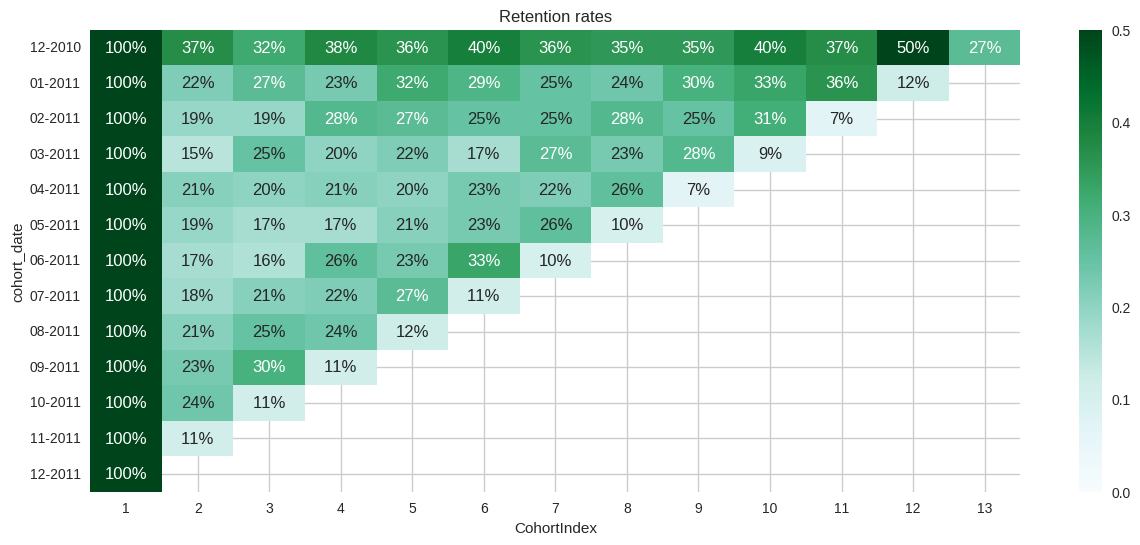

In [158]:
plt.figure(figsize=(15, 6))
plt.title('Retention rates')
sns.heatmap(data = retention, annot = True, fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap = 'BuGn')
plt.show()

**Insights:**
* we can see from the above chart that more users tend to purchase as time goes on.
* The 12-2010 cohort is the strongest. The 02-2011 and 04-2011 cohort are the weaknest cohort.

Text(0, 0.5, '% of Cohort Purchasing')

<Figure size 1500x600 with 0 Axes>

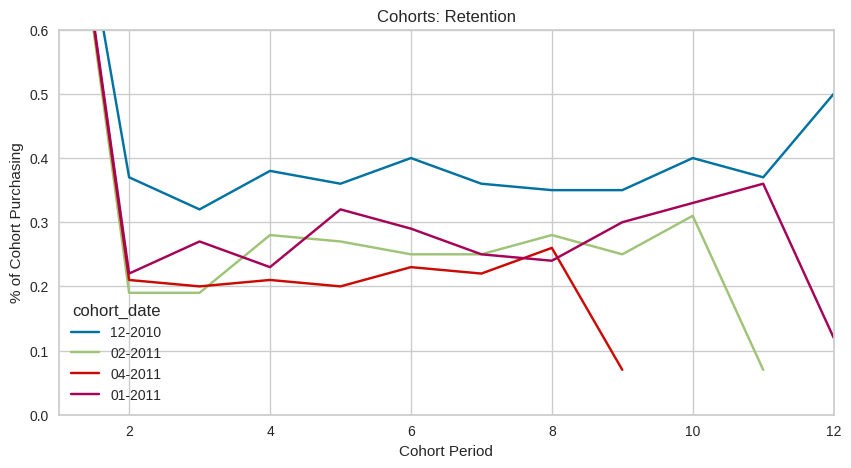

In [159]:
plt.figure(figsize=(15,6))
# retention[list(range(1,14))].plot(figsize=(10,5))
retention.loc[['12-2010', '02-2011', '04-2011','01-2011'],:].T.plot(figsize=(10,5))
# retention.iloc[:,:].T.plot(figsize=(10,5))
plt.title('Cohorts: Retention')
plt.xlim(1,12)
plt.ylim(0,0.6)
plt.xlabel('Cohort Period')
plt.ylabel('% of Cohort Purchasing')

## Create the 2nd Cohort: Average Quantity Sold

### i. Pivot Cohort and Cohort Retention

In [160]:
# --Calculate Average Quantity--
grouping_qty = df.groupby(['cohort_date', 'CohortIndex'])
cohort_data_qty = grouping_qty['Quantity'].mean()
cohort_data_qty = cohort_data_qty.reset_index()
average_quantity = cohort_data_qty.pivot(index='cohort_date',
                                     columns='CohortIndex',
                                     values='Quantity')
average_quantity.index = average_quantity.index.strftime('%m-%Y')

### ii. Visualize analysis of cohort 2 using seaborn and matplotlib modules

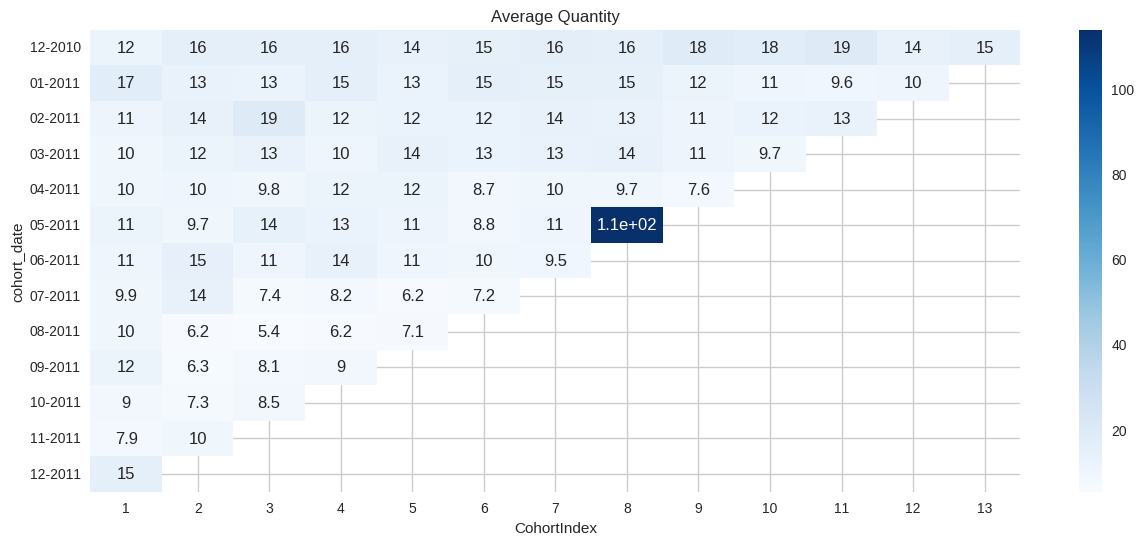

In [161]:
# Plot average quantity
plt.figure(figsize=(15, 6))
plt.title('Average Quantity')
sns.heatmap(data = average_quantity, annot=True, cmap='Blues')
plt.show()

## Create the 3rd Cohort: Average Sales


### i. Pivot Cohort and Cohort Retention

In [162]:
# --Calculate Average Price--
grouping_price = df.groupby(['cohort_date', 'CohortIndex'])
cohort_data_price = grouping_price['TotalPrice'].mean()
cohort_data_price = cohort_data_price.reset_index()
average_price = cohort_data_price.pivot(index='cohort_date',
                                     columns='CohortIndex',
                                     values='TotalPrice')
average_price.index = average_price.index.strftime('%m-%Y')

### ii. Visualize analysis of cohort 3 using seaborn and matplotlib modules

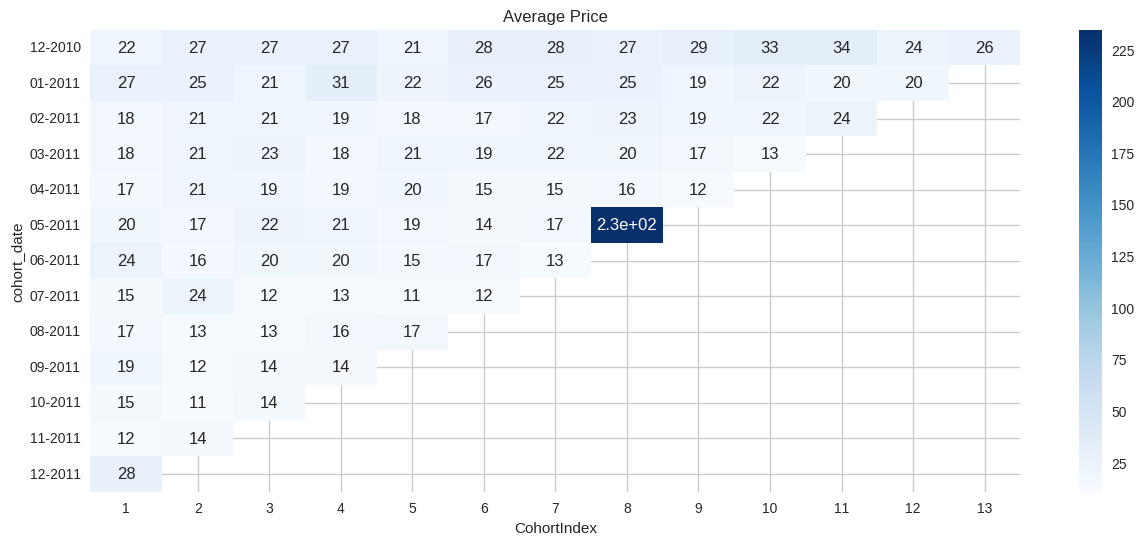

In [163]:
# Plot average sales
plt.figure(figsize=(15, 6))
plt.title('Average Price')
sns.heatmap(data = average_price, annot=True, cmap='Blues')
plt.show()

For e-commerce organisations, cohort analysis is a unique opportunity to find out which clients are the most valuable to their business. by performing Cohort analysis you can get answers to following questions:

- How much effective was a marketing campaign held in a particular time period?
- Did the strategy employed to improve the conversion rates of Customers worked?
- Should I focus more on retention rather than acquiring new customers?
- Are my customer nurturing strategies effective?
- Which marketing channels bring me the best results?
- Is there a seasoanlity pattern in Customer behahiour?